In [1]:
%matplotlib inline

import numpy as np
import copy
import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim, cfg_default_lr, cfg_default_early, cfg_policy_evaluation_maxiter
seed = cfg_seed
env_str=cfg_env
default_lr=cfg_default_lr
default_early=cfg_default_early

from config import cfg_alpha
alpha=cfg_alpha

num_iter_max=200000
env_name = 'CustomCartPole-v0'
env_str=cfg_env
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter1_"

loss_list = []
normalized_loss_list = []

policy_evaluation_maxiter = cfg_policy_evaluation_maxiter
print("policy_evaluation_maxiter",policy_evaluation_maxiter)
print("alpha",alpha)
print("seed",seed)
print(datetime.datetime.now())

policy_evaluation_maxiter 5
alpha 0.2
seed 2
2023-07-23 18:07:45.726873


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)



4 1 2


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_standardvae_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_cartpole_bamdp_standardvae_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

iwvi.load_base(ckpt_key="unweighted")
# iwvi.update_mulogvar_offlinedata()

dec: h_dim 64
base load ckpt ckpt_basevi_cartpole_unweighted
base load self.initial_belief.data.sum() tensor(-12.5076)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(2.6375)
penalty_target_min tensor(-12.1743) penalty_target_max tensor(7.2671)
train_loss:  -10.601994652557373
valid_loss:  -9.932252493286132
h_min_tilde -12.174277 ell_tilde -10.468046220703124 kappa_tilde 0.000765563245792875


In [5]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 7.152557373046875e-07


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):



 1 5.07288122177124

 2 5.027162551879883

 3 5.4059295654296875

 4 6.934374809265137

 5 6.855804443359375

 6 6.9107091426849365

 7 6.835134029388428

 8 6.349040746688843

 9 5.9480133056640625

 10 6.731311798095703

 11 7.003156900405884

 12 6.877726078033447

 13 6.896118640899658

 14 6.699320316314697

 15 6.922468662261963

 16 7.018755912780762

 17 6.798853158950806

 18 6.670200347900391

 19 6.974351644515991

 20 6.79715371131897

 21 7.159348011016846

 22 7.081818580627441

 23 6.9417946338653564

 24 6.772715091705322

 25 6.15366005897522

 26 7.2153966426849365

 27 7.0016796588897705

 28 7.0281736850738525

 29 7.064997673034668

 30 6.9367995262146

 31 7.03110671043396

 32 6.813632965087891

 33 7.217176198959351

 34 6.767458200454712

 35 6.877449989318848

 36 7.161963701248169

 37 6.902125835418701

 38 7.142923593521118

 39 6.877611875534058

 40 6.917608261108398

 41 7.018608570098877

 42 6.876901388168335

 43 3.278383255004883

 44 3.510343551635

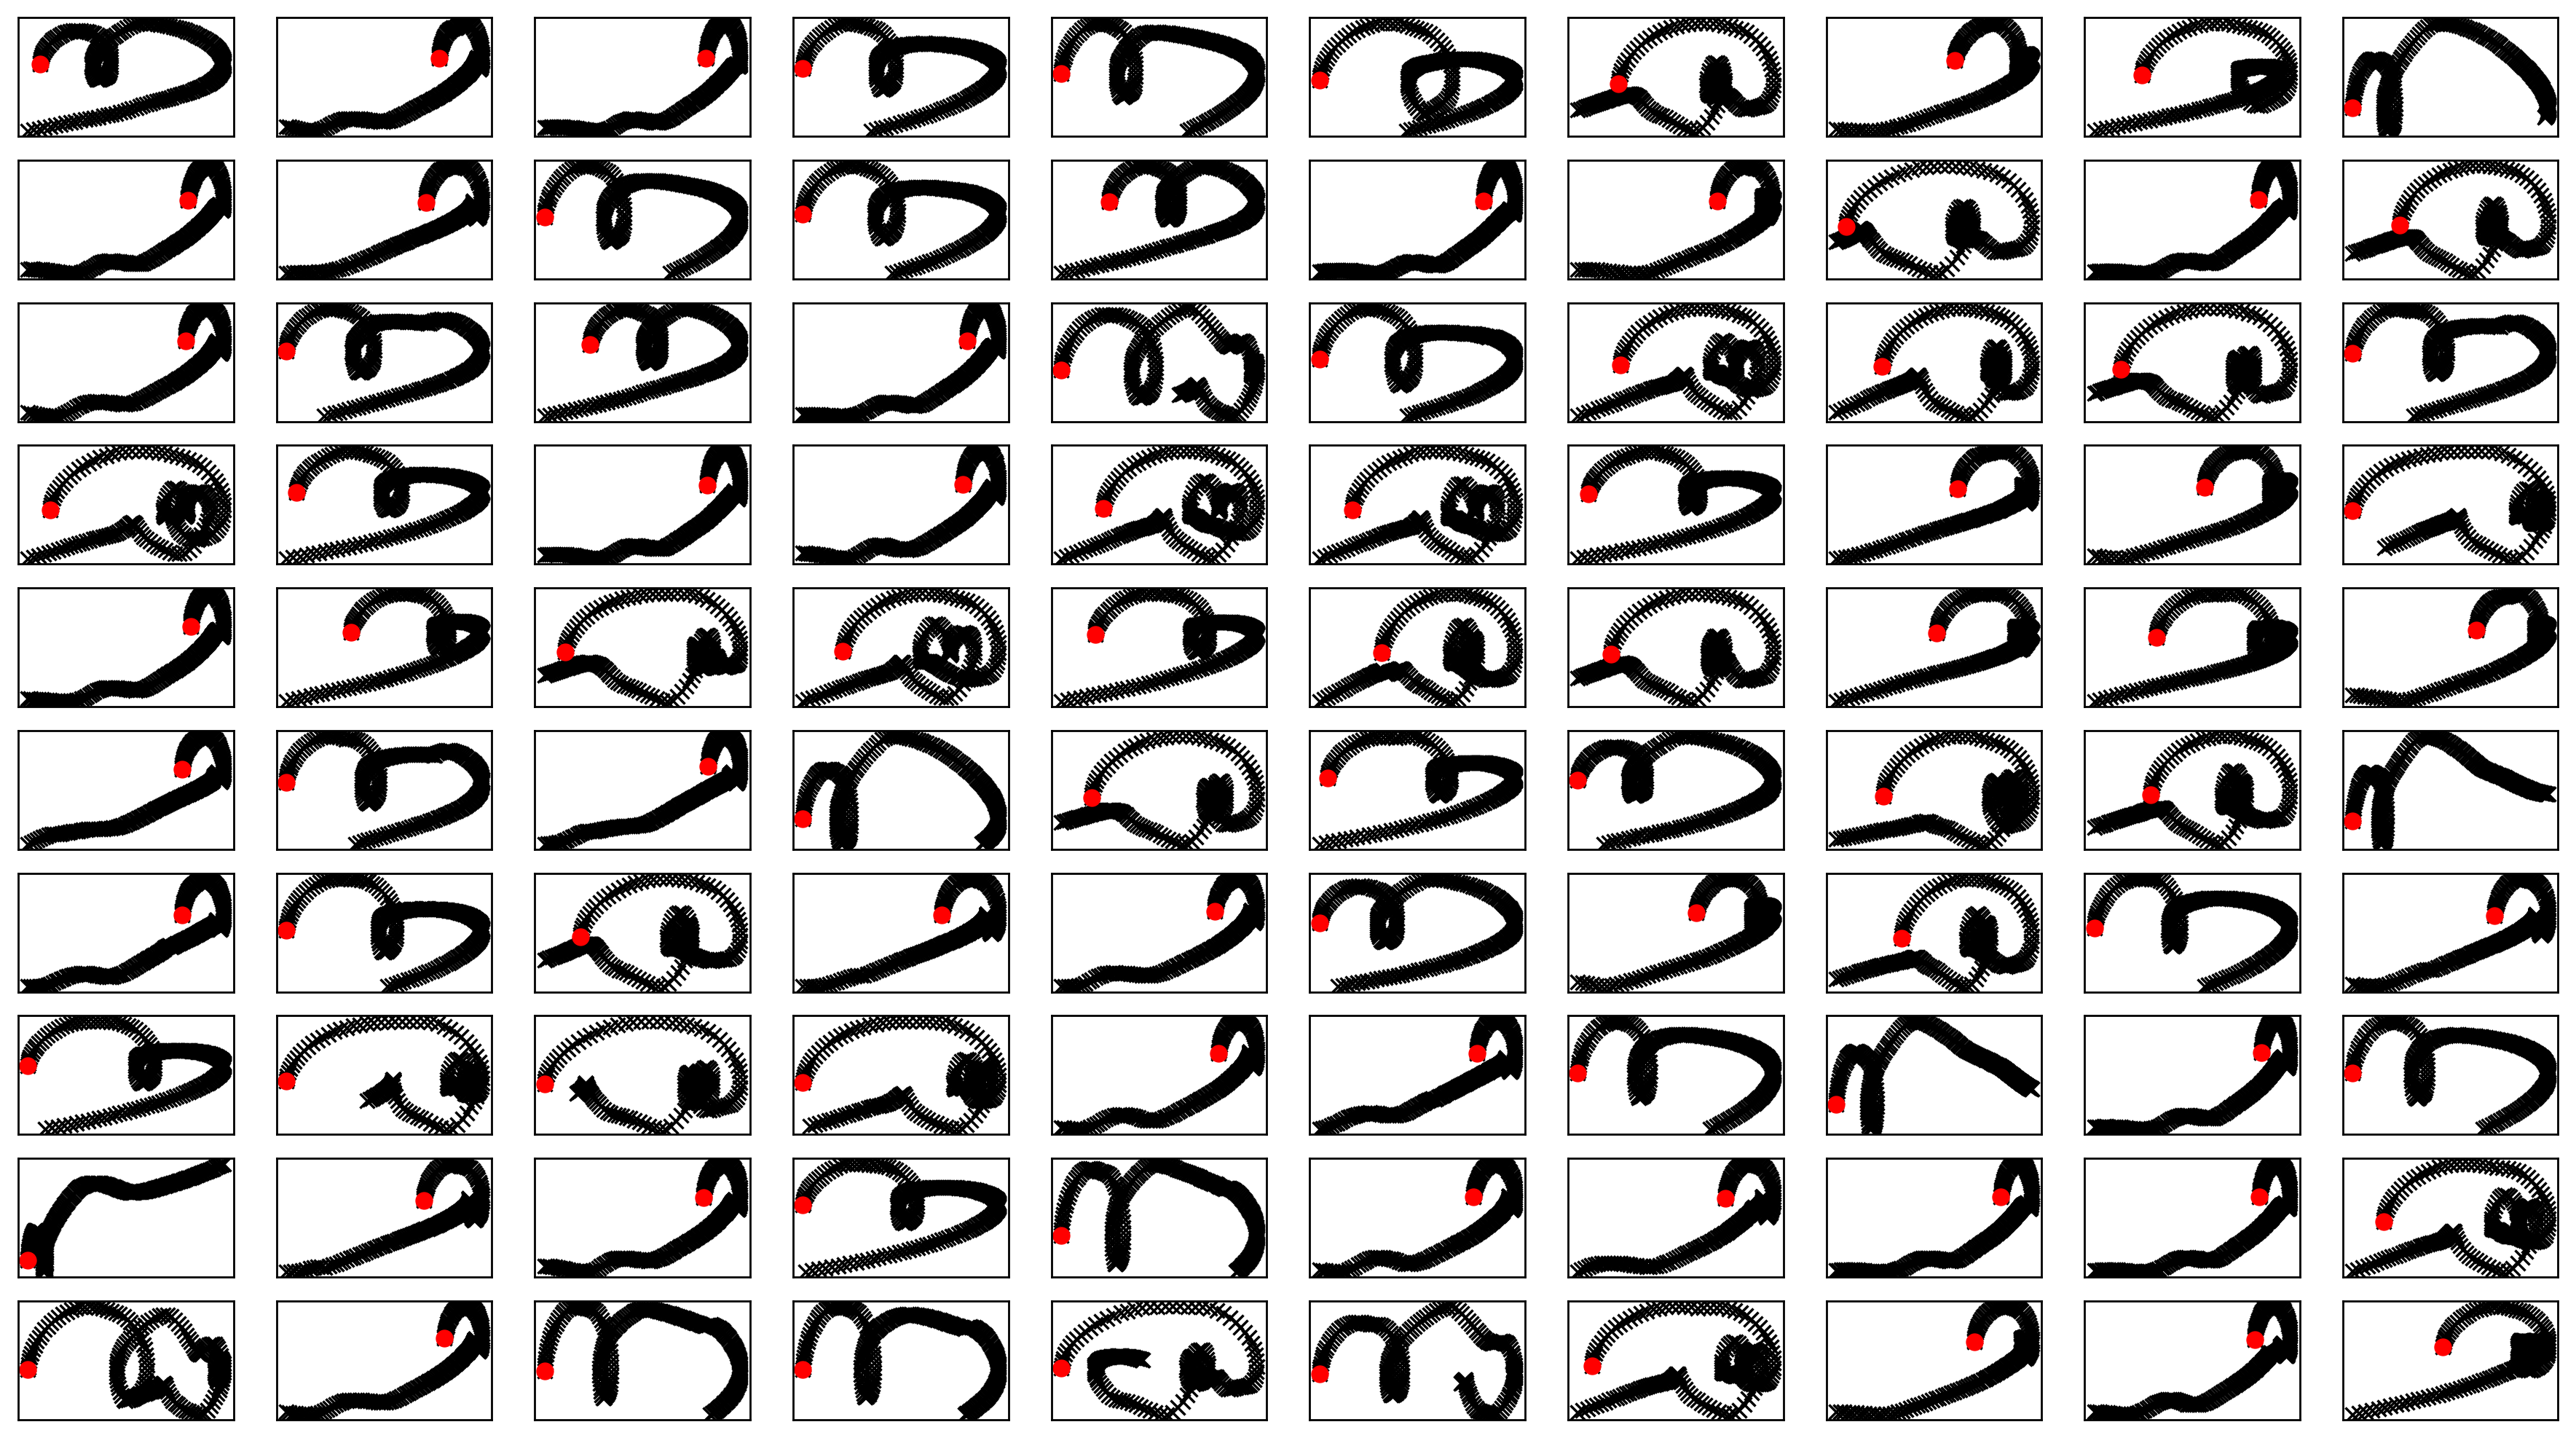

In [6]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

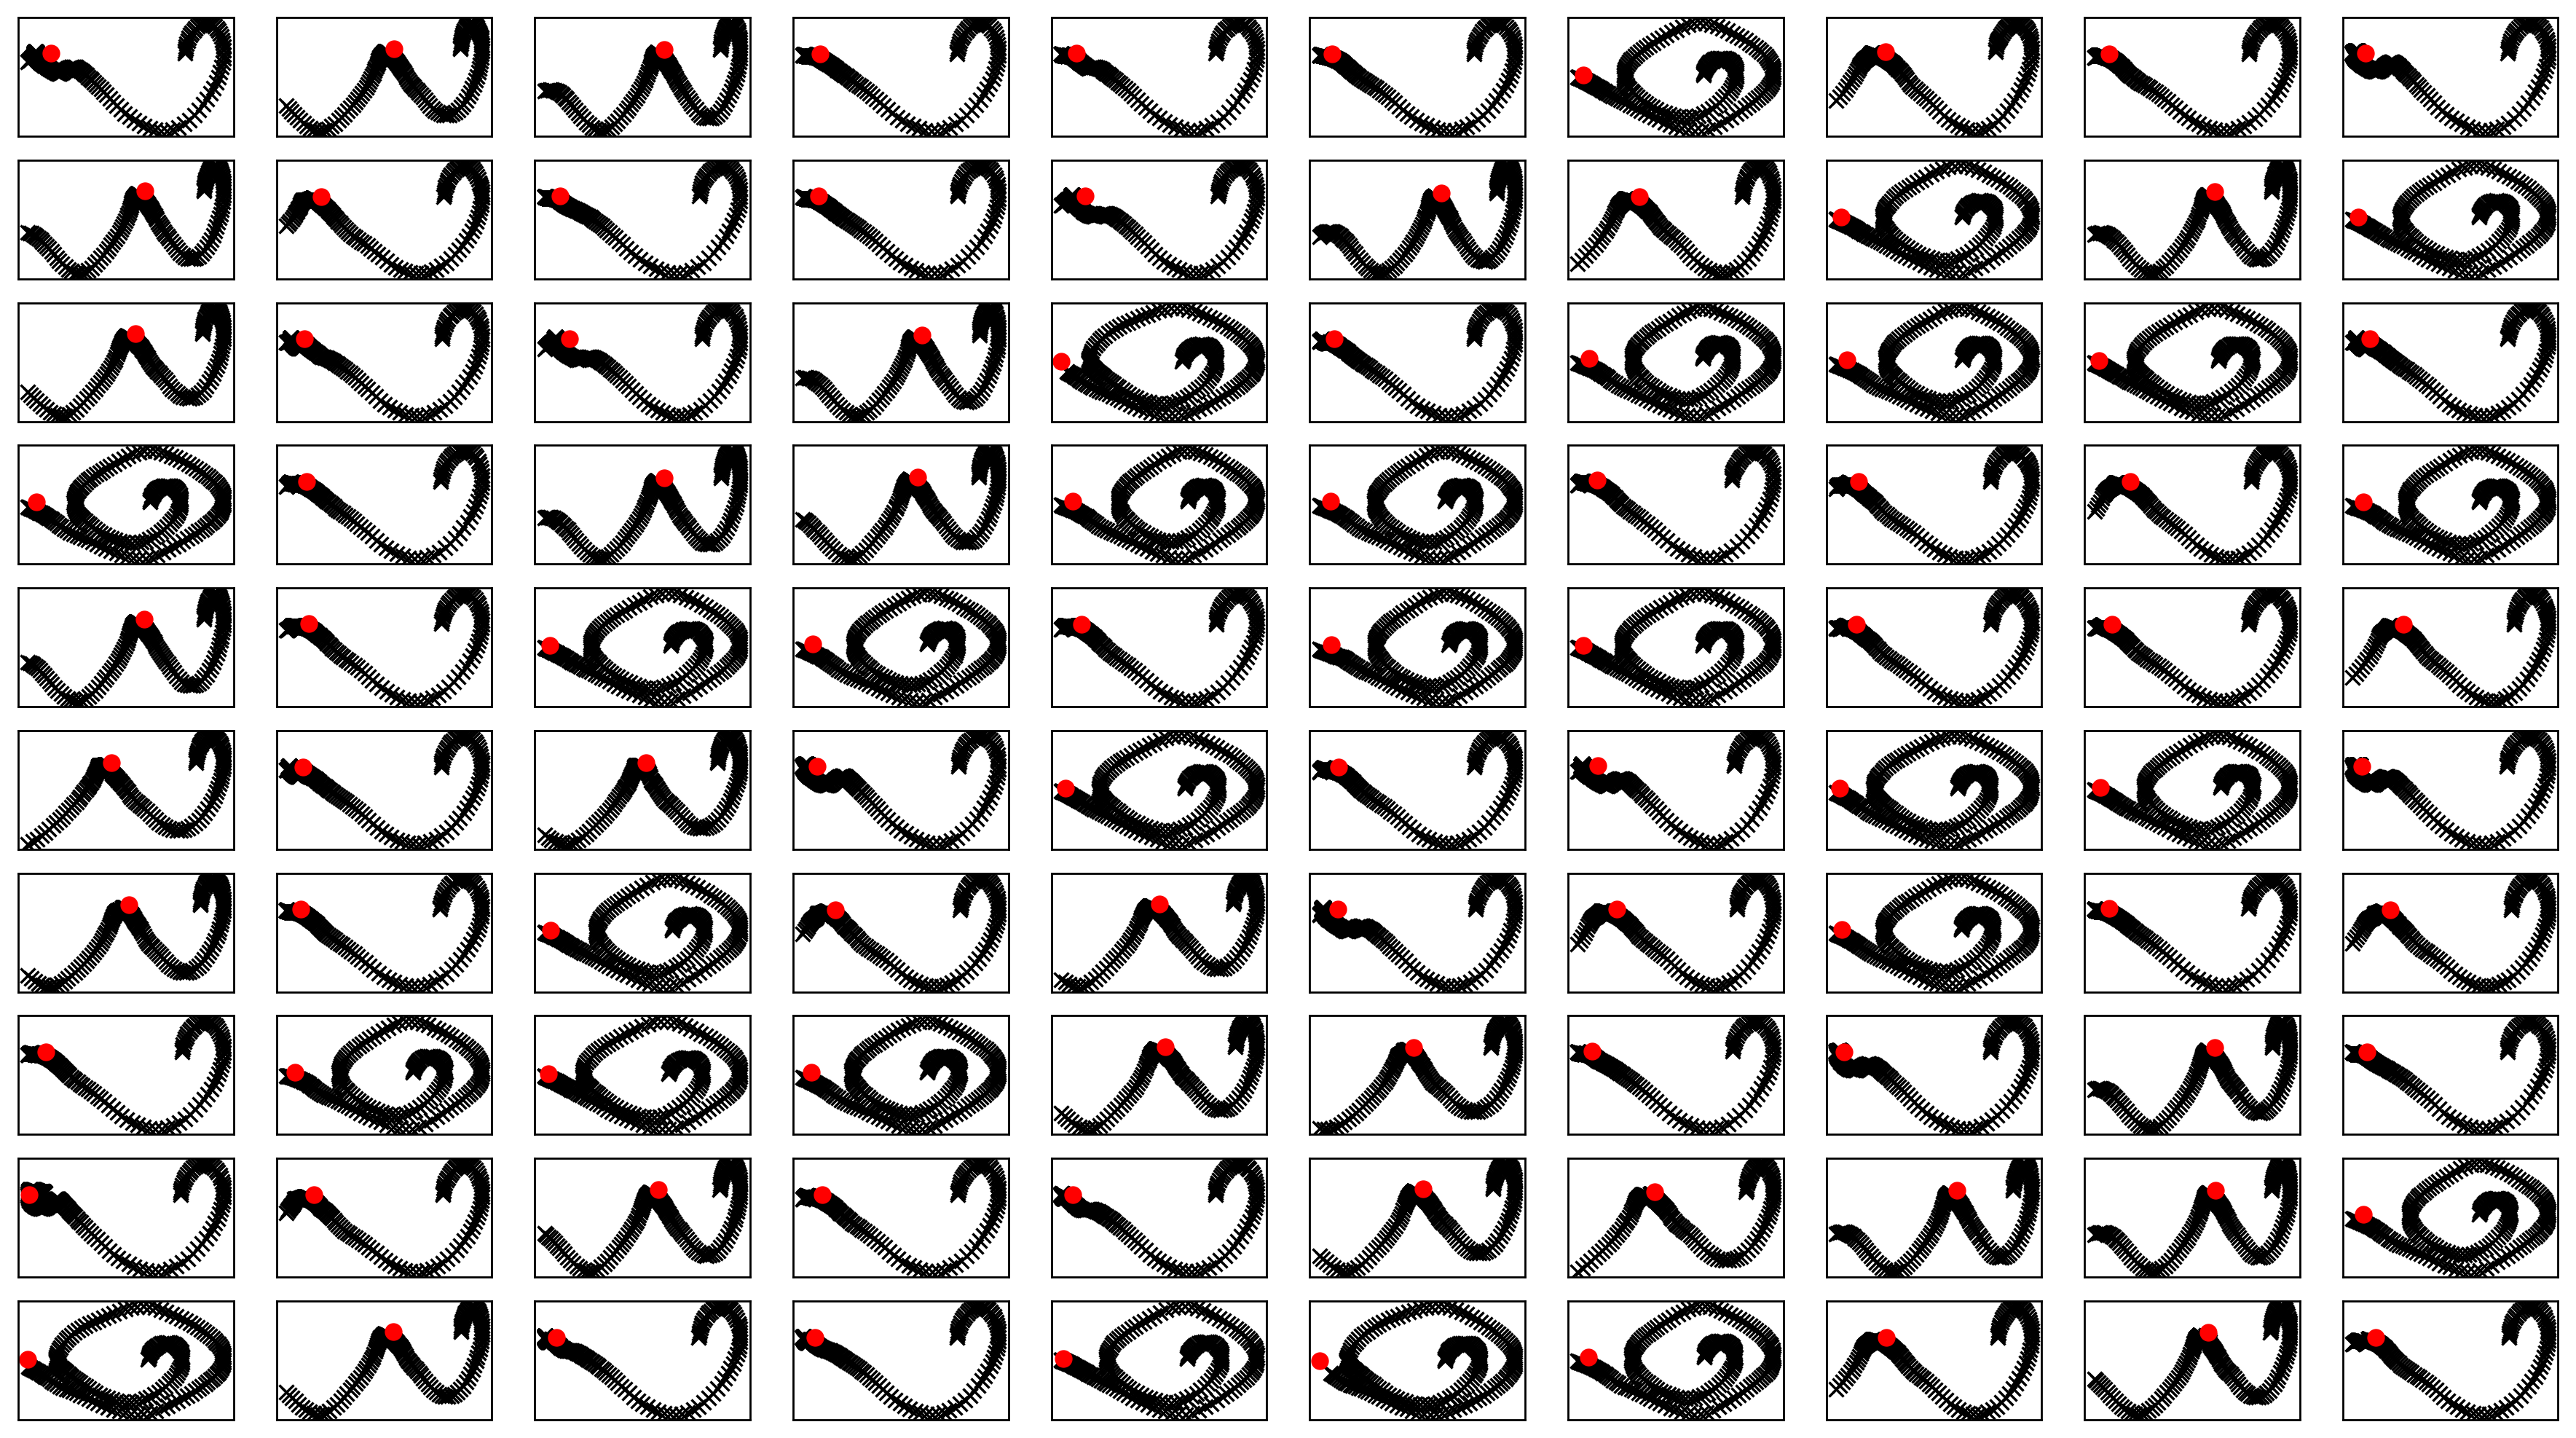

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,2], iwvi.debug_realenv_rolloutdata[i][:,3],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

In [8]:
print(datetime.datetime.now())

2023-07-23 18:17:12.024345


# Iter 1

In [9]:
policy_evaluation_iter=0

In [10]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72
predict diverge [ 1.29283238  7.85068207 12.99254054 26.58395699] [-2.16825944e-03  6.54547721e+00  3.74271857e-01  6.71353275e+00] [19.307684   8.8250065 51.54092   22.740385 ] [ 9.653842   4.4125032 25.77046   11.370193 ] sim_timestep 67

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [11]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.38086  validloss 1.42972±0.00000  bestvalidloss 1.42972  last_update 0
train: iter 1  trainloss 1.29986  validloss 1.37689±0.00000  bestvalidloss 1.37689  last_update 0
train: iter 2  trainloss 1.21223  validloss 1.36666±0.00000  bestvalidloss 1.36666  last_update 0
train: iter 3  trainloss 1.16507  validloss 1.34846±0.00000  bestvalidloss 1.34846  last_update 0
train: iter 4  trainloss 1.14318  validloss 1.34852±0.00000  bestvalidloss 1.34846  last_update 1
train: iter 5  trainloss 1.12645  validloss 1.35097±0.00000  bestvalidloss 1.34846  last_update 2
train: iter 6  trainloss 1.10840  validloss 1.34401±0.00000  bestvalidloss 1.34401  last_update 0
train: iter 7  trainloss 1.09060  validloss 1.34367±0.00000  bestvalidloss 1.34367  last_update 0
train: iter 8  trainloss 1.06902  validloss 1.32631±0.00000  bestvalidloss 1.32631  last_update 0
train: iter 9  trainloss 1.03853  validloss 1.29946±0.00000  bestvalidloss 1.29946  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.75709  validloss 1.04350±0.00000  bestvalidloss 1.01616  last_update 15
train: iter 84  trainloss 0.73946  validloss 1.00428±0.00000  bestvalidloss 1.00428  last_update 0
train: iter 85  trainloss 0.74366  validloss 0.99250±0.00000  bestvalidloss 0.99250  last_update 0
train: iter 86  trainloss 0.73288  validloss 1.01017±0.00000  bestvalidloss 0.99250  last_update 1
train: iter 87  trainloss 0.73538  validloss 0.96342±0.00000  bestvalidloss 0.96342  last_update 0
train: iter 88  trainloss 0.73270  validloss 1.02897±0.00000  bestvalidloss 0.96342  last_update 1
train: iter 89  trainloss 0.72916  validloss 1.03767±0.00000  bestvalidloss 0.96342  last_update 2
train: iter 90  trainloss 0.72725  validloss 0.98524±0.00000  bestvalidloss 0.96342  last_update 3
train: iter 91  trainloss 0.73939  validloss 1.00663±0.00000  bestvalidloss 0.96342  last_update 4
train: iter 92  trainloss 0.73604  validloss 0.95024±0.00000  bestvalidloss 0.95024  last_update 0
train: it

train: iter 166  trainloss 0.68273  validloss 0.86462±0.00000  bestvalidloss 0.80859  last_update 2
train: iter 167  trainloss 0.67850  validloss 0.80899±0.00000  bestvalidloss 0.80859  last_update 3
train: iter 168  trainloss 0.68043  validloss 0.81517±0.00000  bestvalidloss 0.80859  last_update 4
train: iter 169  trainloss 0.68945  validloss 0.83093±0.00000  bestvalidloss 0.80859  last_update 5
train: iter 170  trainloss 0.68289  validloss 0.81317±0.00000  bestvalidloss 0.80859  last_update 6
train: iter 171  trainloss 0.68082  validloss 0.83228±0.00000  bestvalidloss 0.80859  last_update 7
train: iter 172  trainloss 0.68457  validloss 0.82204±0.00000  bestvalidloss 0.80859  last_update 8
train: iter 173  trainloss 0.67752  validloss 0.83512±0.00000  bestvalidloss 0.80859  last_update 9
train: iter 174  trainloss 0.68693  validloss 0.86375±0.00000  bestvalidloss 0.80859  last_update 10
train: iter 175  trainloss 0.68358  validloss 0.82894±0.00000  bestvalidloss 0.80859  last_update 1

train: iter 248  trainloss 0.65656  validloss 0.77777±0.00000  bestvalidloss 0.73858  last_update 1
train: iter 249  trainloss 0.64973  validloss 0.75391±0.00000  bestvalidloss 0.73858  last_update 2
train: iter 250  trainloss 0.65275  validloss 0.74571±0.00000  bestvalidloss 0.73858  last_update 3
train: iter 251  trainloss 0.64906  validloss 0.76273±0.00000  bestvalidloss 0.73858  last_update 4
train: iter 252  trainloss 0.65256  validloss 0.77956±0.00000  bestvalidloss 0.73858  last_update 5
train: iter 253  trainloss 0.65187  validloss 0.74766±0.00000  bestvalidloss 0.73858  last_update 6
train: iter 254  trainloss 0.64976  validloss 0.76501±0.00000  bestvalidloss 0.73858  last_update 7
train: iter 255  trainloss 0.64702  validloss 0.74842±0.00000  bestvalidloss 0.73858  last_update 8
train: iter 256  trainloss 0.65061  validloss 0.74013±0.00000  bestvalidloss 0.73858  last_update 9
train: iter 257  trainloss 0.64744  validloss 0.77098±0.00000  bestvalidloss 0.73858  last_update 10

train: iter 330  trainloss 0.63637  validloss 0.71554±0.00000  bestvalidloss 0.71554  last_update 0
train: iter 331  trainloss 0.61932  validloss 0.73952±0.00000  bestvalidloss 0.71554  last_update 1
train: iter 332  trainloss 0.61921  validloss 0.72456±0.00000  bestvalidloss 0.71554  last_update 2
train: iter 333  trainloss 0.62654  validloss 0.71339±0.00000  bestvalidloss 0.71339  last_update 0
train: iter 334  trainloss 0.62499  validloss 0.74287±0.00000  bestvalidloss 0.71339  last_update 1
train: iter 335  trainloss 0.62778  validloss 0.70949±0.00000  bestvalidloss 0.70949  last_update 0
train: iter 336  trainloss 0.62040  validloss 0.73468±0.00000  bestvalidloss 0.70949  last_update 1
train: iter 337  trainloss 0.63880  validloss 0.73436±0.00000  bestvalidloss 0.70949  last_update 2
train: iter 338  trainloss 0.62763  validloss 0.71149±0.00000  bestvalidloss 0.70949  last_update 3
train: iter 339  trainloss 0.62065  validloss 0.72496±0.00000  bestvalidloss 0.70949  last_update 4


train: iter 412  trainloss 0.60086  validloss 0.68997±0.00000  bestvalidloss 0.67659  last_update 2
train: iter 413  trainloss 0.59619  validloss 0.68514±0.00000  bestvalidloss 0.67659  last_update 3
train: iter 414  trainloss 0.59889  validloss 0.70612±0.00000  bestvalidloss 0.67659  last_update 4
train: iter 415  trainloss 0.59966  validloss 0.70294±0.00000  bestvalidloss 0.67659  last_update 5
train: iter 416  trainloss 0.60112  validloss 0.70614±0.00000  bestvalidloss 0.67659  last_update 6
train: iter 417  trainloss 0.59829  validloss 0.69382±0.00000  bestvalidloss 0.67659  last_update 7
train: iter 418  trainloss 0.60481  validloss 0.71630±0.00000  bestvalidloss 0.67659  last_update 8
train: iter 419  trainloss 0.59638  validloss 0.67615±0.00000  bestvalidloss 0.67615  last_update 0
train: iter 420  trainloss 0.60034  validloss 0.70820±0.00000  bestvalidloss 0.67615  last_update 1
train: iter 421  trainloss 0.59315  validloss 0.68888±0.00000  bestvalidloss 0.67615  last_update 2


train: iter 494  trainloss 0.58290  validloss 0.67841±0.00000  bestvalidloss 0.66594  last_update 54
train: iter 495  trainloss 0.57728  validloss 0.67567±0.00000  bestvalidloss 0.66594  last_update 55
train: iter 496  trainloss 0.58335  validloss 0.68011±0.00000  bestvalidloss 0.66594  last_update 56
train: iter 497  trainloss 0.58292  validloss 0.68905±0.00000  bestvalidloss 0.66594  last_update 57
train: iter 498  trainloss 0.58299  validloss 0.67647±0.00000  bestvalidloss 0.66594  last_update 58
train: iter 499  trainloss 0.58860  validloss 0.69092±0.00000  bestvalidloss 0.66594  last_update 59
train: iter 500  trainloss 0.58247  validloss 0.67584±0.00000  bestvalidloss 0.66594  last_update 60
train: iter 501  trainloss 0.57340  validloss 0.67797±0.00000  bestvalidloss 0.66594  last_update 61
train: iter 502  trainloss 0.57875  validloss 0.70448±0.00000  bestvalidloss 0.66594  last_update 62
train: iter 503  trainloss 0.58293  validloss 0.70226±0.00000  bestvalidloss 0.66594  last_

train: iter 576  trainloss 0.57751  validloss 0.67818±0.00000  bestvalidloss 0.66519  last_update 17
train: iter 577  trainloss 0.56724  validloss 0.67849±0.00000  bestvalidloss 0.66519  last_update 18
train: iter 578  trainloss 0.57664  validloss 0.68768±0.00000  bestvalidloss 0.66519  last_update 19
train: iter 579  trainloss 0.56918  validloss 0.66350±0.00000  bestvalidloss 0.66350  last_update 0
train: iter 580  trainloss 0.56290  validloss 0.68770±0.00000  bestvalidloss 0.66350  last_update 1
train: iter 581  trainloss 0.56704  validloss 0.67718±0.00000  bestvalidloss 0.66350  last_update 2
train: iter 582  trainloss 0.56347  validloss 0.68380±0.00000  bestvalidloss 0.66350  last_update 3
train: iter 583  trainloss 0.56191  validloss 0.67973±0.00000  bestvalidloss 0.66350  last_update 4
train: iter 584  trainloss 0.57749  validloss 0.70021±0.00000  bestvalidloss 0.66350  last_update 5
train: iter 585  trainloss 0.56427  validloss 0.68021±0.00000  bestvalidloss 0.66350  last_update

train: iter 658  trainloss 0.55562  validloss 0.71293±0.00000  bestvalidloss 0.65508  last_update 6
train: iter 659  trainloss 0.55390  validloss 0.68375±0.00000  bestvalidloss 0.65508  last_update 7
train: iter 660  trainloss 0.55556  validloss 0.66852±0.00000  bestvalidloss 0.65508  last_update 8
train: iter 661  trainloss 0.55542  validloss 0.66440±0.00000  bestvalidloss 0.65508  last_update 9
train: iter 662  trainloss 0.55055  validloss 0.66966±0.00000  bestvalidloss 0.65508  last_update 10
train: iter 663  trainloss 0.55087  validloss 0.69044±0.00000  bestvalidloss 0.65508  last_update 11
train: iter 664  trainloss 0.55826  validloss 0.69474±0.00000  bestvalidloss 0.65508  last_update 12
train: iter 665  trainloss 0.55323  validloss 0.67776±0.00000  bestvalidloss 0.65508  last_update 13
train: iter 666  trainloss 0.54959  validloss 0.70437±0.00000  bestvalidloss 0.65508  last_update 14
train: iter 667  trainloss 0.55336  validloss 0.67018±0.00000  bestvalidloss 0.65508  last_upda

train: iter 740  trainloss 0.53820  validloss 0.67100±0.00000  bestvalidloss 0.65319  last_update 28
train: iter 741  trainloss 0.54761  validloss 0.66853±0.00000  bestvalidloss 0.65319  last_update 29
train: iter 742  trainloss 0.54628  validloss 0.67814±0.00000  bestvalidloss 0.65319  last_update 30
train: iter 743  trainloss 0.55244  validloss 0.69216±0.00000  bestvalidloss 0.65319  last_update 31
train: iter 744  trainloss 0.54461  validloss 0.68509±0.00000  bestvalidloss 0.65319  last_update 32
train: iter 745  trainloss 0.53809  validloss 0.67072±0.00000  bestvalidloss 0.65319  last_update 33
train: iter 746  trainloss 0.54408  validloss 0.70563±0.00000  bestvalidloss 0.65319  last_update 34
train: iter 747  trainloss 0.54655  validloss 0.67038±0.00000  bestvalidloss 0.65319  last_update 35
train: iter 748  trainloss 0.54571  validloss 0.66037±0.00000  bestvalidloss 0.65319  last_update 36
train: iter 749  trainloss 0.54210  validloss 0.66443±0.00000  bestvalidloss 0.65319  last_

In [12]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -6.872244707447291
valid_loss:  -13.418948521995546
weight_alpha 1.0 h_min_tilde -12.174277 ell_tilde -8.181585470356943 kappa_tilde 0.0005004573871414921
train_loss:  -5.6474409424781795
valid_loss:  -6.155824387359619
weight_alpha 0.2 h_min_tilde -12.174277 ell_tilde -5.749117631454468 kappa_tilde 0.0003945100194237009


In [13]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()

weight_alpha 0.2
train_weighted_vae: enc_dec
train: iter 0  trainloss -1118.88943  validloss -1229.78438±0.00000  bestvalidloss -1229.78438  last_update 0
train: iter 1  trainloss -1138.10477  validloss -1249.53760±0.00000  bestvalidloss -1249.53760  last_update 0
train: iter 2  trainloss -1133.36835  validloss -1196.17568±0.00000  bestvalidloss -1249.53760  last_update 1
train: iter 3  trainloss -1154.68174  validloss -1206.27421±0.00000  bestvalidloss -1249.53760  last_update 2
train: iter 4  trainloss -1145.87218  validloss -1229.23360±0.00000  bestvalidloss -1249.53760  last_update 3
train: iter 5  trainloss -1169.08102  validloss -1242.06774±0.00000  bestvalidloss -1249.53760  last_update 4
train: iter 6  trainloss -1155.48261  validloss -1259.00378±0.00000  bestvalidloss -1259.00378  last_update 0
train: iter 7  trainloss -1169.77021  validloss -1131.81989±0.00000  bestvalidloss -1259.00378  last_update 1
train: iter 8  trainloss -1178.13294  validloss -1294.23819±0.00000  bestva

train: iter 74  trainloss -1335.32043  validloss -1420.95227±0.00000  bestvalidloss -1434.92740  last_update 3
train: iter 75  trainloss -1328.41162  validloss -1363.84237±0.00000  bestvalidloss -1434.92740  last_update 4
train: iter 76  trainloss -1348.64189  validloss -1426.34345±0.00000  bestvalidloss -1434.92740  last_update 5
train: iter 77  trainloss -1359.95705  validloss -1449.24570±0.00000  bestvalidloss -1449.24570  last_update 0
train: iter 78  trainloss -1342.40671  validloss -1424.89772±0.00000  bestvalidloss -1449.24570  last_update 1
train: iter 79  trainloss -1341.77351  validloss -1381.12460±0.00000  bestvalidloss -1449.24570  last_update 2
train: iter 80  trainloss -1359.63226  validloss -1393.34008±0.00000  bestvalidloss -1449.24570  last_update 3
train: iter 81  trainloss -1364.01995  validloss -1449.34464±0.00000  bestvalidloss -1449.34464  last_update 0
train: iter 82  trainloss -1351.98456  validloss -1413.43849±0.00000  bestvalidloss -1449.34464  last_update 1
t

train: iter 148  trainloss -1473.33709  validloss -1475.10708±0.00000  bestvalidloss -1550.38230  last_update 9
train: iter 149  trainloss -1475.43925  validloss -1530.35398±0.00000  bestvalidloss -1550.38230  last_update 10
train: iter 150  trainloss -1465.96668  validloss -1538.08293±0.00000  bestvalidloss -1550.38230  last_update 11
train: iter 151  trainloss -1462.57785  validloss -1519.83214±0.00000  bestvalidloss -1550.38230  last_update 12
train: iter 152  trainloss -1459.25537  validloss -1509.86734±0.00000  bestvalidloss -1550.38230  last_update 13
train: iter 153  trainloss -1464.58057  validloss -1552.34093±0.00000  bestvalidloss -1552.34093  last_update 0
train: iter 154  trainloss -1477.70453  validloss -1503.32496±0.00000  bestvalidloss -1552.34093  last_update 1
train: iter 155  trainloss -1475.56954  validloss -1548.75554±0.00000  bestvalidloss -1552.34093  last_update 2
train: iter 156  trainloss -1473.30519  validloss -1543.22875±0.00000  bestvalidloss -1552.34093  la

train: iter 222  trainloss -1519.07918  validloss -1559.28808±0.00000  bestvalidloss -1646.25465  last_update 13
train: iter 223  trainloss -1552.51937  validloss -1593.59417±0.00000  bestvalidloss -1646.25465  last_update 14
train: iter 224  trainloss -1552.99774  validloss -1644.03832±0.00000  bestvalidloss -1646.25465  last_update 15
train: iter 225  trainloss -1542.05477  validloss -1608.44659±0.00000  bestvalidloss -1646.25465  last_update 16
train: iter 226  trainloss -1549.67010  validloss -1619.56093±0.00000  bestvalidloss -1646.25465  last_update 17
train: iter 227  trainloss -1558.64558  validloss -1615.38500±0.00000  bestvalidloss -1646.25465  last_update 18
train: iter 228  trainloss -1551.10803  validloss -1649.91087±0.00000  bestvalidloss -1649.91087  last_update 0
train: iter 229  trainloss -1552.66404  validloss -1649.98306±0.00000  bestvalidloss -1649.98306  last_update 0
train: iter 230  trainloss -1551.57909  validloss -1587.57578±0.00000  bestvalidloss -1649.98306  

train: iter 295  trainloss -1585.45915  validloss -1643.98397±0.00000  bestvalidloss -1732.84761  last_update 24
train: iter 296  trainloss -1589.59986  validloss -1624.07015±0.00000  bestvalidloss -1732.84761  last_update 25
train: iter 297  trainloss -1564.30092  validloss -1629.51144±0.00000  bestvalidloss -1732.84761  last_update 26
train: iter 298  trainloss -1604.72265  validloss -1518.99538±0.00000  bestvalidloss -1732.84761  last_update 27
train: iter 299  trainloss -1608.86943  validloss -1707.43672±0.00000  bestvalidloss -1732.84761  last_update 28
train: iter 300  trainloss -1589.50802  validloss -1673.93965±0.00000  bestvalidloss -1732.84761  last_update 29
train: iter 301  trainloss -1598.90766  validloss -1655.84835±0.00000  bestvalidloss -1732.84761  last_update 30
train: iter 302  trainloss -1586.63886  validloss -1646.28145±0.00000  bestvalidloss -1732.84761  last_update 31
train: iter 303  trainloss -1598.57646  validloss -1670.86806±0.00000  bestvalidloss -1732.84761

train: iter 368  trainloss -1655.74005  validloss -1737.24814±0.00000  bestvalidloss -1762.51342  last_update 6
train: iter 369  trainloss -1657.94791  validloss -1730.55620±0.00000  bestvalidloss -1762.51342  last_update 7
train: iter 370  trainloss -1650.44475  validloss -1736.46316±0.00000  bestvalidloss -1762.51342  last_update 8
train: iter 371  trainloss -1664.63221  validloss -1724.63882±0.00000  bestvalidloss -1762.51342  last_update 9
train: iter 372  trainloss -1656.89465  validloss -1763.71811±0.00000  bestvalidloss -1763.71811  last_update 0
train: iter 373  trainloss -1653.13578  validloss -1737.68536±0.00000  bestvalidloss -1763.71811  last_update 1
train: iter 374  trainloss -1662.82503  validloss -1718.45140±0.00000  bestvalidloss -1763.71811  last_update 2
train: iter 375  trainloss -1642.15976  validloss -1688.88742±0.00000  bestvalidloss -1763.71811  last_update 3
train: iter 376  trainloss -1668.62061  validloss -1697.20017±0.00000  bestvalidloss -1763.71811  last_u

train: iter 441  trainloss -1703.29275  validloss -1759.20440±0.00000  bestvalidloss -1801.39136  last_update 16
train: iter 442  trainloss -1692.29025  validloss -1737.13559±0.00000  bestvalidloss -1801.39136  last_update 17
train: iter 443  trainloss -1707.91088  validloss -1760.56507±0.00000  bestvalidloss -1801.39136  last_update 18
train: iter 444  trainloss -1703.51324  validloss -1781.15297±0.00000  bestvalidloss -1801.39136  last_update 19
train: iter 445  trainloss -1693.34301  validloss -1780.42025±0.00000  bestvalidloss -1801.39136  last_update 20
train: iter 446  trainloss -1709.06099  validloss -1779.50370±0.00000  bestvalidloss -1801.39136  last_update 21
train: iter 447  trainloss -1700.82954  validloss -1753.83779±0.00000  bestvalidloss -1801.39136  last_update 22
train: iter 448  trainloss -1712.18320  validloss -1784.58581±0.00000  bestvalidloss -1801.39136  last_update 23
train: iter 449  trainloss -1696.74823  validloss -1715.64760±0.00000  bestvalidloss -1801.39136

train: iter 514  trainloss -1732.83959  validloss -1805.39870±0.00000  bestvalidloss -1870.35898  last_update 27
train: iter 515  trainloss -1737.04746  validloss -1810.64312±0.00000  bestvalidloss -1870.35898  last_update 28
train: iter 516  trainloss -1746.34829  validloss -1831.57265±0.00000  bestvalidloss -1870.35898  last_update 29
train: iter 517  trainloss -1747.33171  validloss -1795.99115±0.00000  bestvalidloss -1870.35898  last_update 30
train: iter 518  trainloss -1736.66146  validloss -1838.70756±0.00000  bestvalidloss -1870.35898  last_update 31
train: iter 519  trainloss -1734.01455  validloss -1778.31806±0.00000  bestvalidloss -1870.35898  last_update 32
train: iter 520  trainloss -1735.58234  validloss -1800.82340±0.00000  bestvalidloss -1870.35898  last_update 33
train: iter 521  trainloss -1718.44492  validloss -1793.99571±0.00000  bestvalidloss -1870.35898  last_update 34
train: iter 522  trainloss -1743.65975  validloss -1754.96230±0.00000  bestvalidloss -1870.35898

train: iter 587  trainloss -1755.56963  validloss -1808.12489±0.00000  bestvalidloss -1870.35898  last_update 100
train: fin
penalty_target_min tensor(-12.3232) penalty_target_max tensor(7.7985)


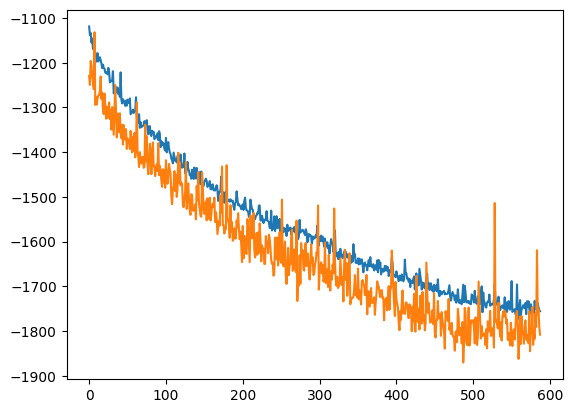

alpha 0.2 default_lr 0.0005


In [14]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
    print("alpha",alpha, "default_lr", default_lr)

In [15]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [16]:
print(datetime.datetime.now())

2023-07-23 18:43:35.052202


# Iter2

In [17]:
policy_evaluation_iter=1

In [18]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25
predict diverge [15.24443563  8.87135456 -0.3586699  -1.91641947] [ 0.16444009  0.09912423 -0.08647242 -0.17802303] [19.307684   8.8250065 51.54092   22.740385 ] [ 9.653842   4.4125032 25.77046   11.370193 ] sim_timestep 193

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50
predict diverge [ -3.07270956  -1.74373698  -5.69965766 -26.49488463] [ 0.01577508 -1.08532612 -0.3202023  -8.43986355] [19.307684   8.8250065 51.54092   22.740385 ] [ 9.653842   4.4125032 25.77046   11.370193 ] sim_timestep 79

 51

 52

 53

 54

 55

 56
predict diverge [ -6.23643613  -9.43496648  -6.65722532 -21.45780434] [-0.08212426 -4.43915257 -0.3862651  -1.49681681] [19.307684   8.8250065 51.54092   22.740385 ] [ 9.653842   4.4125032 25.77046   11.370193 ] sim_timestep 92

 57

 58

 59

 60

 61

 62

 63

 64

 65

In [19]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.10095  validloss 1.54468±0.00000  bestvalidloss 1.54468  last_update 0
train: iter 1  trainloss 0.86058  validloss 0.90444±0.00000  bestvalidloss 0.90444  last_update 0
train: iter 2  trainloss 0.80618  validloss 0.83065±0.00000  bestvalidloss 0.83065  last_update 0
train: iter 3  trainloss 0.77439  validloss 0.83865±0.00000  bestvalidloss 0.83065  last_update 1
train: iter 4  trainloss 0.75883  validloss 0.83149±0.00000  bestvalidloss 0.83065  last_update 2
train: iter 5  trainloss 0.74928  validloss 0.83684±0.00000  bestvalidloss 0.83065  last_update 3
train: iter 6  trainloss 0.73631  validloss 0.83190±0.00000  bestvalidloss 0.83065  last_update 4
train: iter 7  trainloss 0.73548  validloss 0.84972±0.00000  bestvalidloss 0.83065  last_update 5
train: iter 8  trainloss 0.72868  validloss 0.82409±0.00000  bestvalidloss 0.82409  last_update 0
train: iter 9  trainloss 0.72494  validloss 0.84788±0.00000  bestvalidloss 0.82409  last_update 1
train: iter 10  trai

train: iter 83  trainloss 0.63889  validloss 0.88822±0.00000  bestvalidloss 0.81244  last_update 48
train: iter 84  trainloss 0.64106  validloss 0.85727±0.00000  bestvalidloss 0.81244  last_update 49
train: iter 85  trainloss 0.64617  validloss 0.85285±0.00000  bestvalidloss 0.81244  last_update 50
train: iter 86  trainloss 0.63699  validloss 0.83624±0.00000  bestvalidloss 0.81244  last_update 51
train: iter 87  trainloss 0.63958  validloss 0.85518±0.00000  bestvalidloss 0.81244  last_update 52
train: iter 88  trainloss 0.64078  validloss 0.86836±0.00000  bestvalidloss 0.81244  last_update 53
train: iter 89  trainloss 0.64601  validloss 0.86006±0.00000  bestvalidloss 0.81244  last_update 54
train: iter 90  trainloss 0.63713  validloss 0.85466±0.00000  bestvalidloss 0.81244  last_update 55
train: iter 91  trainloss 0.64178  validloss 0.86701±0.00000  bestvalidloss 0.81244  last_update 56
train: iter 92  trainloss 0.63959  validloss 0.87291±0.00000  bestvalidloss 0.81244  last_update 57


In [20]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -6.98302017840147
valid_loss:  -14.469162029266357
weight_alpha 1.0 h_min_tilde -12.323219 ell_tilde -8.480248548574448 kappa_tilde 0.0005101130810703385
train_loss:  -6.031952655124664
valid_loss:  -6.586954347991943
weight_alpha 0.2 h_min_tilde -12.323219 ell_tilde -6.14295299369812 kappa_tilde 0.000402250326658128


In [21]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.2
train_weighted_vae: enc_dec
train: iter 0  trainloss -1211.75312  validloss -1314.28015±0.00000  bestvalidloss -1314.28015  last_update 0
train: iter 1  trainloss -1224.81738  validloss -1296.90368±0.00000  bestvalidloss -1314.28015  last_update 1
train: iter 2  trainloss -1221.03743  validloss -1339.89480±0.00000  bestvalidloss -1339.89480  last_update 0
train: iter 3  trainloss -1220.73477  validloss -1320.09764±0.00000  bestvalidloss -1339.89480  last_update 1
train: iter 4  trainloss -1220.95123  validloss -1277.97337±0.00000  bestvalidloss -1339.89480  last_update 2
train: iter 5  trainloss -1215.50310  validloss -1343.97883±0.00000  bestvalidloss -1343.97883  last_update 0
train: iter 6  trainloss -1215.55331  validloss -1351.25671±0.00000  bestvalidloss -1351.25671  last_update 0
train: iter 7  trainloss -1218.08969  validloss -1360.75097±0.00000  bestvalidloss -1360.75097  last_update 0
train: iter 8  trainloss -1220.55998  validloss -1316.45142±0.00000  bestva

train: iter 74  trainloss -1235.80320  validloss -1343.30397±0.00000  bestvalidloss -1380.89518  last_update 27
train: iter 75  trainloss -1240.29974  validloss -1367.30420±0.00000  bestvalidloss -1380.89518  last_update 28
train: iter 76  trainloss -1238.40483  validloss -1381.68837±0.00000  bestvalidloss -1381.68837  last_update 0
train: iter 77  trainloss -1216.42261  validloss -1348.91705±0.00000  bestvalidloss -1381.68837  last_update 1
train: iter 78  trainloss -1236.42705  validloss -1333.25333±0.00000  bestvalidloss -1381.68837  last_update 2
train: iter 79  trainloss -1237.10557  validloss -1359.57224±0.00000  bestvalidloss -1381.68837  last_update 3
train: iter 80  trainloss -1237.14985  validloss -1341.95412±0.00000  bestvalidloss -1381.68837  last_update 4
train: iter 81  trainloss -1237.38355  validloss -1330.64139±0.00000  bestvalidloss -1381.68837  last_update 5
train: iter 82  trainloss -1237.87010  validloss -1367.55718±0.00000  bestvalidloss -1381.68837  last_update 6

train: iter 147  trainloss -1238.26949  validloss -1365.81160±0.00000  bestvalidloss -1388.92835  last_update 33
train: iter 148  trainloss -1245.26127  validloss -1341.37729±0.00000  bestvalidloss -1388.92835  last_update 34
train: iter 149  trainloss -1240.87640  validloss -1340.82231±0.00000  bestvalidloss -1388.92835  last_update 35
train: iter 150  trainloss -1240.89657  validloss -1374.54088±0.00000  bestvalidloss -1388.92835  last_update 36
train: iter 151  trainloss -1243.09398  validloss -1379.75148±0.00000  bestvalidloss -1388.92835  last_update 37
train: iter 152  trainloss -1224.38952  validloss -1340.93083±0.00000  bestvalidloss -1388.92835  last_update 38
train: iter 153  trainloss -1221.16441  validloss -1340.03458±0.00000  bestvalidloss -1388.92835  last_update 39
train: iter 154  trainloss -1226.69699  validloss -1357.19447±0.00000  bestvalidloss -1388.92835  last_update 40
train: iter 155  trainloss -1238.73647  validloss -1357.49247±0.00000  bestvalidloss -1388.92835

train: iter 220  trainloss -1233.25384  validloss -1346.02089±0.00000  bestvalidloss -1396.71384  last_update 60
train: iter 221  trainloss -1235.89166  validloss -1354.00543±0.00000  bestvalidloss -1396.71384  last_update 61
train: iter 222  trainloss -1243.11628  validloss -1364.00222±0.00000  bestvalidloss -1396.71384  last_update 62
train: iter 223  trainloss -1245.89184  validloss -1376.72133±0.00000  bestvalidloss -1396.71384  last_update 63
train: iter 224  trainloss -1245.55273  validloss -1390.35267±0.00000  bestvalidloss -1396.71384  last_update 64
train: iter 225  trainloss -1239.41701  validloss -1379.93696±0.00000  bestvalidloss -1396.71384  last_update 65
train: iter 226  trainloss -1233.31140  validloss -1368.03413±0.00000  bestvalidloss -1396.71384  last_update 66
train: iter 227  trainloss -1235.44511  validloss -1346.82334±0.00000  bestvalidloss -1396.71384  last_update 67
train: iter 228  trainloss -1225.16447  validloss -1370.67981±0.00000  bestvalidloss -1396.71384

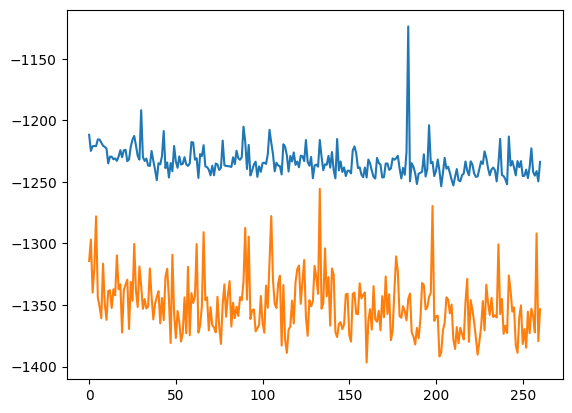

alpha 0.2 default_lr 0.0005


In [22]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [23]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)


In [24]:
print(datetime.datetime.now())

2023-07-23 19:07:29.316707


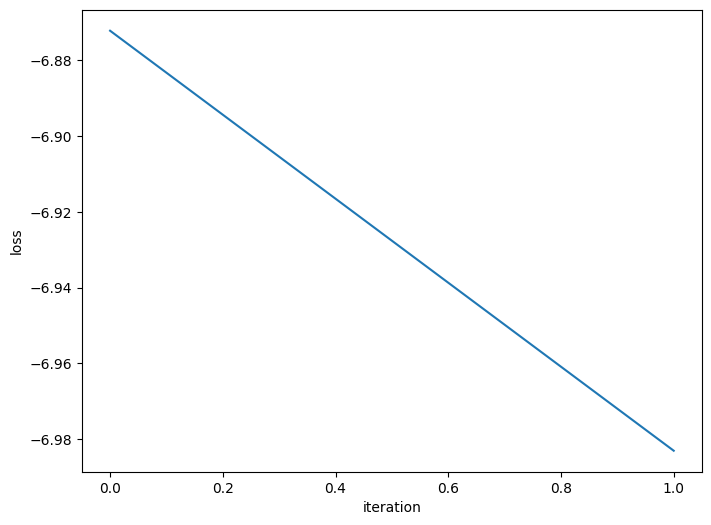

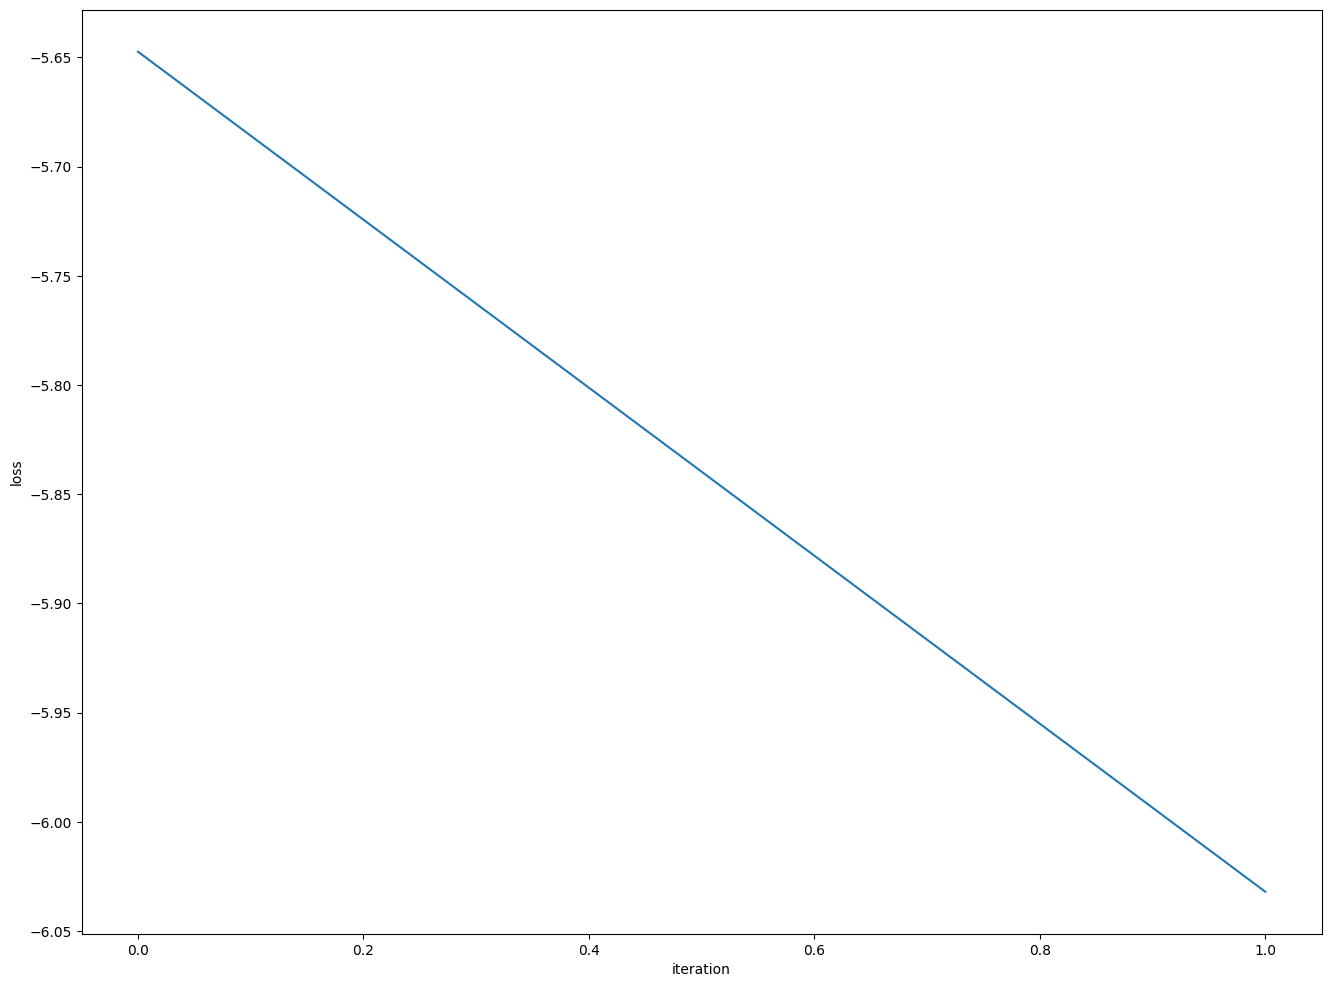

In [25]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(16,12))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [26]:
# if policy_evaluation_iter<policy_evaluation_maxiter:
#     normalized_loss_array = np.array(normalized_loss_list)
#     plt.figure(figsize=(16,12))
#     plt.plot(normalized_loss_array[:,0])
#     plt.xlabel("iteration")
#     plt.ylabel("loss")


# Iter 3

In [27]:
policy_evaluation_iter=2

In [28]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33
predict diverge [ -5.06858658  -5.18140799  -5.15257247 -25.64718971] [-0.07280432 -0.10323535 -0.32659256 -9.10282622] [19.307684   8.8250065 51.54092   22.740385 ] [ 9.653842   4.4125032 25.77046   11.370193 ] sim_timestep 64

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68
predict diverge [ -8.15849961  -4.52562054  -5.324676   -26.68212879] [-0.08846861  0.16820567 -0.2889839  -9.67387872] [19.307684   8.8250065 51.54092   22.740385 ] [ 9.653842   4.4125032 25.77046   11.370193 ] sim_timestep 132

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98
predict diverge [ -5.89305633  -8.95104972  -6.65407874 -1

In [29]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.71169  validloss 0.98929±0.00000  bestvalidloss 0.98929  last_update 0
train: iter 1  trainloss 0.67361  validloss 0.84491±0.00000  bestvalidloss 0.84491  last_update 0
train: iter 2  trainloss 0.67031  validloss 0.82273±0.00000  bestvalidloss 0.82273  last_update 0
train: iter 3  trainloss 0.67089  validloss 0.83109±0.00000  bestvalidloss 0.82273  last_update 1
train: iter 4  trainloss 0.66938  validloss 0.82086±0.00000  bestvalidloss 0.82086  last_update 0
train: iter 5  trainloss 0.66478  validloss 0.82531±0.00000  bestvalidloss 0.82086  last_update 1
train: iter 6  trainloss 0.66094  validloss 0.83200±0.00000  bestvalidloss 0.82086  last_update 2
train: iter 7  trainloss 0.66655  validloss 0.81853±0.00000  bestvalidloss 0.81853  last_update 0
train: iter 8  trainloss 0.67402  validloss 0.81626±0.00000  bestvalidloss 0.81626  last_update 0
train: iter 9  trainloss 0.66187  validloss 0.83000±0.00000  bestvalidloss 0.81626  last_update 1
train: iter 10  trai

train: iter 84  trainloss 0.61938  validloss 0.79896±0.00000  bestvalidloss 0.76338  last_update 41
train: iter 85  trainloss 0.62020  validloss 0.79143±0.00000  bestvalidloss 0.76338  last_update 42
train: iter 86  trainloss 0.62340  validloss 0.81720±0.00000  bestvalidloss 0.76338  last_update 43
train: iter 87  trainloss 0.62469  validloss 0.81666±0.00000  bestvalidloss 0.76338  last_update 44
train: iter 88  trainloss 0.62319  validloss 0.81267±0.00000  bestvalidloss 0.76338  last_update 45
train: iter 89  trainloss 0.62378  validloss 0.79705±0.00000  bestvalidloss 0.76338  last_update 46
train: iter 90  trainloss 0.62002  validloss 0.77794±0.00000  bestvalidloss 0.76338  last_update 47
train: iter 91  trainloss 0.62771  validloss 0.80555±0.00000  bestvalidloss 0.76338  last_update 48
train: iter 92  trainloss 0.61705  validloss 0.80817±0.00000  bestvalidloss 0.76338  last_update 49
train: iter 93  trainloss 0.62502  validloss 0.80333±0.00000  bestvalidloss 0.76338  last_update 50


In [30]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -6.528697488880158
valid_loss:  -12.746397370529174
weight_alpha 1.0 h_min_tilde -12.323948 ell_tilde -7.772237465209961 kappa_tilde 0.00046871913849522433
train_loss:  -6.021201447963715
valid_loss:  -6.3397147315979
weight_alpha 0.2 h_min_tilde -12.323948 ell_tilde -6.084904104690552 kappa_tilde 0.00040035105996367456


In [31]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.2
train_weighted_vae: enc_dec
train: iter 0  trainloss -1187.44358  validloss -1258.27654±0.00000  bestvalidloss -1258.27654  last_update 0
train: iter 1  trainloss -1196.43042  validloss -1279.64412±0.00000  bestvalidloss -1279.64412  last_update 0
train: iter 2  trainloss -1197.83379  validloss -1276.38152±0.00000  bestvalidloss -1279.64412  last_update 1
train: iter 3  trainloss -1198.41679  validloss -1312.80237±0.00000  bestvalidloss -1312.80237  last_update 0
train: iter 4  trainloss -1192.82491  validloss -1257.60677±0.00000  bestvalidloss -1312.80237  last_update 1
train: iter 5  trainloss -1193.54885  validloss -1279.77440±0.00000  bestvalidloss -1312.80237  last_update 2
train: iter 6  trainloss -1193.44483  validloss -1263.49742±0.00000  bestvalidloss -1312.80237  last_update 3
train: iter 7  trainloss -1197.31152  validloss -1286.80580±0.00000  bestvalidloss -1312.80237  last_update 4
train: iter 8  trainloss -1190.79454  validloss -1257.90551±0.00000  bestva

train: iter 74  trainloss -1199.16838  validloss -1321.22263±0.00000  bestvalidloss -1337.42535  last_update 26
train: iter 75  trainloss -1180.67767  validloss -1302.98925±0.00000  bestvalidloss -1337.42535  last_update 27
train: iter 76  trainloss -1204.80152  validloss -1342.95506±0.00000  bestvalidloss -1342.95506  last_update 0
train: iter 77  trainloss -1202.13158  validloss -1336.58110±0.00000  bestvalidloss -1342.95506  last_update 1
train: iter 78  trainloss -1203.90340  validloss -1341.70336±0.00000  bestvalidloss -1342.95506  last_update 2
train: iter 79  trainloss -1204.60630  validloss -1308.83604±0.00000  bestvalidloss -1342.95506  last_update 3
train: iter 80  trainloss -1198.47465  validloss -1279.82139±0.00000  bestvalidloss -1342.95506  last_update 4
train: iter 81  trainloss -1211.88181  validloss -1308.01977±0.00000  bestvalidloss -1342.95506  last_update 5
train: iter 82  trainloss -1212.16152  validloss -1317.84285±0.00000  bestvalidloss -1342.95506  last_update 6

train: iter 148  trainloss -1215.65300  validloss -1360.08797±0.00000  bestvalidloss -1364.59062  last_update 12
train: iter 149  trainloss -1219.90027  validloss -1332.51284±0.00000  bestvalidloss -1364.59062  last_update 13
train: iter 150  trainloss -1204.64922  validloss -1365.93726±0.00000  bestvalidloss -1365.93726  last_update 0
train: iter 151  trainloss -1218.80240  validloss -1358.30925±0.00000  bestvalidloss -1365.93726  last_update 1
train: iter 152  trainloss -1218.12827  validloss -1347.29120±0.00000  bestvalidloss -1365.93726  last_update 2
train: iter 153  trainloss -1213.71259  validloss -1326.10278±0.00000  bestvalidloss -1365.93726  last_update 3
train: iter 154  trainloss -1198.30283  validloss -1242.23688±0.00000  bestvalidloss -1365.93726  last_update 4
train: iter 155  trainloss -1207.85519  validloss -1293.55647±0.00000  bestvalidloss -1365.93726  last_update 5
train: iter 156  trainloss -1219.29120  validloss -1369.66689±0.00000  bestvalidloss -1369.66689  last

train: iter 221  trainloss -1215.43217  validloss -1329.62276±0.00000  bestvalidloss -1401.33055  last_update 5
train: iter 222  trainloss -1232.03074  validloss -1391.10296±0.00000  bestvalidloss -1401.33055  last_update 6
train: iter 223  trainloss -1237.68751  validloss -1362.39385±0.00000  bestvalidloss -1401.33055  last_update 7
train: iter 224  trainloss -1227.12964  validloss -1363.97112±0.00000  bestvalidloss -1401.33055  last_update 8
train: iter 225  trainloss -1228.03586  validloss -1292.82224±0.00000  bestvalidloss -1401.33055  last_update 9
train: iter 226  trainloss -1233.97468  validloss -1374.55933±0.00000  bestvalidloss -1401.33055  last_update 10
train: iter 227  trainloss -1238.60091  validloss -1355.03997±0.00000  bestvalidloss -1401.33055  last_update 11
train: iter 228  trainloss -1232.88538  validloss -1381.71841±0.00000  bestvalidloss -1401.33055  last_update 12
train: iter 229  trainloss -1236.14097  validloss -1384.61006±0.00000  bestvalidloss -1401.33055  las

train: iter 294  trainloss -1245.20556  validloss -1394.07781±0.00000  bestvalidloss -1416.11351  last_update 12
train: iter 295  trainloss -1233.59487  validloss -1353.19275±0.00000  bestvalidloss -1416.11351  last_update 13
train: iter 296  trainloss -1244.41836  validloss -1373.39510±0.00000  bestvalidloss -1416.11351  last_update 14
train: iter 297  trainloss -1241.19151  validloss -1404.00034±0.00000  bestvalidloss -1416.11351  last_update 15
train: iter 298  trainloss -1253.33992  validloss -1385.19551±0.00000  bestvalidloss -1416.11351  last_update 16
train: iter 299  trainloss -1237.40148  validloss -1386.88992±0.00000  bestvalidloss -1416.11351  last_update 17
train: iter 300  trainloss -1231.09553  validloss -1363.50742±0.00000  bestvalidloss -1416.11351  last_update 18
train: iter 301  trainloss -1237.10882  validloss -1391.14803±0.00000  bestvalidloss -1416.11351  last_update 19
train: iter 302  trainloss -1232.16458  validloss -1407.57060±0.00000  bestvalidloss -1416.11351

train: iter 367  trainloss -1255.40482  validloss -1430.40910±0.00000  bestvalidloss -1443.82993  last_update 18
train: iter 368  trainloss -1256.40838  validloss -1418.81787±0.00000  bestvalidloss -1443.82993  last_update 19
train: iter 369  trainloss -1257.65346  validloss -1399.60609±0.00000  bestvalidloss -1443.82993  last_update 20
train: iter 370  trainloss -1252.14198  validloss -1409.26986±0.00000  bestvalidloss -1443.82993  last_update 21
train: iter 371  trainloss -1261.59954  validloss -1435.87468±0.00000  bestvalidloss -1443.82993  last_update 22
train: iter 372  trainloss -1260.32381  validloss -1412.97933±0.00000  bestvalidloss -1443.82993  last_update 23
train: iter 373  trainloss -1261.49340  validloss -1367.27702±0.00000  bestvalidloss -1443.82993  last_update 24
train: iter 374  trainloss -1253.78000  validloss -1412.51239±0.00000  bestvalidloss -1443.82993  last_update 25
train: iter 375  trainloss -1262.64909  validloss -1421.28771±0.00000  bestvalidloss -1443.82993

train: iter 440  trainloss -1255.01461  validloss -1436.34440±0.00000  bestvalidloss -1451.78884  last_update 35
train: iter 441  trainloss -1267.32963  validloss -1413.41456±0.00000  bestvalidloss -1451.78884  last_update 36
train: iter 442  trainloss -1261.54186  validloss -1455.17664±0.00000  bestvalidloss -1455.17664  last_update 0
train: iter 443  trainloss -1265.89672  validloss -1446.24938±0.00000  bestvalidloss -1455.17664  last_update 1
train: iter 444  trainloss -1266.05430  validloss -1401.34453±0.00000  bestvalidloss -1455.17664  last_update 2
train: iter 445  trainloss -1270.26145  validloss -1424.67226±0.00000  bestvalidloss -1455.17664  last_update 3
train: iter 446  trainloss -1272.80160  validloss -1400.03049±0.00000  bestvalidloss -1455.17664  last_update 4
train: iter 447  trainloss -1270.49012  validloss -1440.68026±0.00000  bestvalidloss -1455.17664  last_update 5
train: iter 448  trainloss -1259.76442  validloss -1424.28554±0.00000  bestvalidloss -1455.17664  last

train: iter 513  trainloss -1258.62653  validloss -1454.67554±0.00000  bestvalidloss -1478.93705  last_update 4
train: iter 514  trainloss -1184.10259  validloss -1309.05029±0.00000  bestvalidloss -1478.93705  last_update 5
train: iter 515  trainloss -1274.11240  validloss -1441.07474±0.00000  bestvalidloss -1478.93705  last_update 6
train: iter 516  trainloss -1272.85786  validloss -1461.85635±0.00000  bestvalidloss -1478.93705  last_update 7
train: iter 517  trainloss -1287.13959  validloss -1431.58888±0.00000  bestvalidloss -1478.93705  last_update 8
train: iter 518  trainloss -1271.61815  validloss -1456.03803±0.00000  bestvalidloss -1478.93705  last_update 9
train: iter 519  trainloss -1280.44159  validloss -1469.20777±0.00000  bestvalidloss -1478.93705  last_update 10
train: iter 520  trainloss -1276.92753  validloss -1439.72666±0.00000  bestvalidloss -1478.93705  last_update 11
train: iter 521  trainloss -1280.58149  validloss -1456.42547±0.00000  bestvalidloss -1478.93705  last

train: iter 586  trainloss -1266.31933  validloss -1429.68024±0.00000  bestvalidloss -1481.28066  last_update 33
train: iter 587  trainloss -1282.61332  validloss -1431.16821±0.00000  bestvalidloss -1481.28066  last_update 34
train: iter 588  trainloss -1284.58028  validloss -1451.64403±0.00000  bestvalidloss -1481.28066  last_update 35
train: iter 589  trainloss -1283.89895  validloss -1453.95644±0.00000  bestvalidloss -1481.28066  last_update 36
train: iter 590  trainloss -1290.91562  validloss -1470.73901±0.00000  bestvalidloss -1481.28066  last_update 37
train: iter 591  trainloss -1278.92375  validloss -1465.71526±0.00000  bestvalidloss -1481.28066  last_update 38
train: iter 592  trainloss -1277.39439  validloss -1433.36853±0.00000  bestvalidloss -1481.28066  last_update 39
train: iter 593  trainloss -1278.86597  validloss -1460.40464±0.00000  bestvalidloss -1481.28066  last_update 40
train: iter 594  trainloss -1275.82466  validloss -1461.65129±0.00000  bestvalidloss -1481.28066

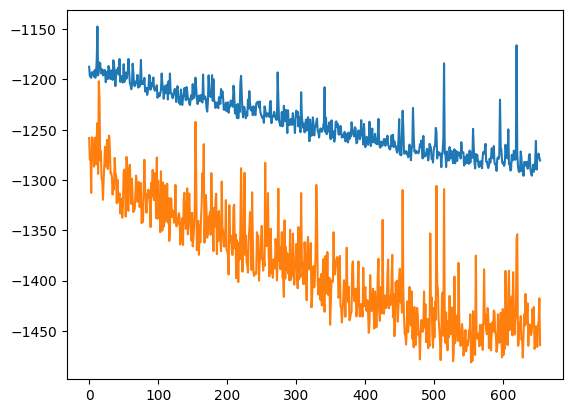

alpha 0.2 default_lr 0.0005


In [32]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [33]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [34]:
print(datetime.datetime.now())

2023-07-23 19:32:52.775704


# Iter 4

In [35]:
policy_evaluation_iter=3

In [36]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23
predict diverge [ -6.37108186  -9.46670286  -4.1663754  -18.05425188] [-0.21397204 -0.83835894 -0.25948032 -0.19860965] [19.307684   8.8250065 51.54092   22.740385 ] [ 9.653842   4.4125032 25.77046   11.370193 ] sim_timestep 99

 24

 25

 26
predict diverge [ -4.99389544  -8.99076047  -4.22340554 -14.56590533] [-0.22160521 -0.87644328 -0.23401259 -0.6901215 ] [19.307684   8.8250065 51.54092   22.740385 ] [ 9.653842   4.4125032 25.77046   11.370193 ] sim_timestep 65

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90
predict diverge [ -4.39403031  -9.10878499  -3.82180945 -13.35840226] [-0.22551295 -0.56649335 -0.1

In [37]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.75878  validloss 1.42753±0.00000  bestvalidloss 1.42753  last_update 0
train: iter 1  trainloss 0.67712  validloss 0.87102±0.00000  bestvalidloss 0.87102  last_update 0
train: iter 2  trainloss 0.67878  validloss 0.82044±0.00000  bestvalidloss 0.82044  last_update 0
train: iter 3  trainloss 0.67517  validloss 0.83418±0.00000  bestvalidloss 0.82044  last_update 1
train: iter 4  trainloss 0.66727  validloss 0.82764±0.00000  bestvalidloss 0.82044  last_update 2
train: iter 5  trainloss 0.66399  validloss 0.86323±0.00000  bestvalidloss 0.82044  last_update 3
train: iter 6  trainloss 0.66003  validloss 0.89476±0.00000  bestvalidloss 0.82044  last_update 4
train: iter 7  trainloss 0.66047  validloss 0.86091±0.00000  bestvalidloss 0.82044  last_update 5
train: iter 8  trainloss 0.65975  validloss 0.83869±0.00000  bestvalidloss 0.82044  last_update 6
train: iter 9  trainloss 0.65635  validloss 0.84858±0.00000  bestvalidloss 0.82044  last_update 7
train: iter 10  trai

train: iter 83  trainloss 0.62170  validloss 0.88835±0.00000  bestvalidloss 0.82044  last_update 81
train: iter 84  trainloss 0.62082  validloss 0.91582±0.00000  bestvalidloss 0.82044  last_update 82
train: iter 85  trainloss 0.62874  validloss 0.90493±0.00000  bestvalidloss 0.82044  last_update 83
train: iter 86  trainloss 0.62501  validloss 0.90750±0.00000  bestvalidloss 0.82044  last_update 84
train: iter 87  trainloss 0.62827  validloss 0.90987±0.00000  bestvalidloss 0.82044  last_update 85
train: iter 88  trainloss 0.62068  validloss 0.90310±0.00000  bestvalidloss 0.82044  last_update 86
train: iter 89  trainloss 0.62711  validloss 0.92739±0.00000  bestvalidloss 0.82044  last_update 87
train: iter 90  trainloss 0.62459  validloss 0.88530±0.00000  bestvalidloss 0.82044  last_update 88
train: iter 91  trainloss 0.62285  validloss 0.90098±0.00000  bestvalidloss 0.82044  last_update 89
train: iter 92  trainloss 0.62086  validloss 0.88964±0.00000  bestvalidloss 0.82044  last_update 90


In [38]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -9.149903266906737
valid_loss:  -19.963115647888184
weight_alpha 1.0 h_min_tilde -12.323841 ell_tilde -11.312545743103026 kappa_tilde 0.0009943997224884375
train_loss:  -6.808572066688538
valid_loss:  -7.105974688816071
weight_alpha 0.2 h_min_tilde -12.323841 ell_tilde -6.868052591114044 kappa_tilde 0.0004281256387838194


In [39]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.2
train_weighted_vae: enc_dec
train: iter 0  trainloss -1342.25333  validloss -1423.09569±0.00000  bestvalidloss -1423.09569  last_update 0
train: iter 1  trainloss -1342.46825  validloss -1381.32747±0.00000  bestvalidloss -1423.09569  last_update 1
train: iter 2  trainloss -1357.94757  validloss -1480.81088±0.00000  bestvalidloss -1480.81088  last_update 0
train: iter 3  trainloss -1339.29671  validloss -1452.59306±0.00000  bestvalidloss -1480.81088  last_update 1
train: iter 4  trainloss -1358.25138  validloss -1437.05556±0.00000  bestvalidloss -1480.81088  last_update 2
train: iter 5  trainloss -1361.04388  validloss -1432.43277±0.00000  bestvalidloss -1480.81088  last_update 3
train: iter 6  trainloss -1354.86115  validloss -1388.98823±0.00000  bestvalidloss -1480.81088  last_update 4
train: iter 7  trainloss -1350.90340  validloss -1474.89496±0.00000  bestvalidloss -1480.81088  last_update 5
train: iter 8  trainloss -1343.36567  validloss -1475.58697±0.00000  bestva

train: iter 74  trainloss -1344.25755  validloss -1452.78985±0.00000  bestvalidloss -1483.41443  last_update 7
train: iter 75  trainloss -1347.76985  validloss -1409.47131±0.00000  bestvalidloss -1483.41443  last_update 8
train: iter 76  trainloss -1363.37446  validloss -1456.84706±0.00000  bestvalidloss -1483.41443  last_update 9
train: iter 77  trainloss -1360.40355  validloss -1444.52380±0.00000  bestvalidloss -1483.41443  last_update 10
train: iter 78  trainloss -1367.19351  validloss -1462.60834±0.00000  bestvalidloss -1483.41443  last_update 11
train: iter 79  trainloss -1369.70878  validloss -1457.63286±0.00000  bestvalidloss -1483.41443  last_update 12
train: iter 80  trainloss -1358.15009  validloss -1441.70331±0.00000  bestvalidloss -1483.41443  last_update 13
train: iter 81  trainloss -1365.89489  validloss -1475.62091±0.00000  bestvalidloss -1483.41443  last_update 14
train: iter 82  trainloss -1362.22358  validloss -1452.89829±0.00000  bestvalidloss -1483.41443  last_updat

train: iter 148  trainloss -1372.36856  validloss -1463.21450±0.00000  bestvalidloss -1493.96462  last_update 17
train: iter 149  trainloss -1372.52169  validloss -1389.00376±0.00000  bestvalidloss -1493.96462  last_update 18
train: iter 150  trainloss -1371.70007  validloss -1460.91751±0.00000  bestvalidloss -1493.96462  last_update 19
train: iter 151  trainloss -1374.35312  validloss -1441.81332±0.00000  bestvalidloss -1493.96462  last_update 20
train: iter 152  trainloss -1383.87728  validloss -1459.19010±0.00000  bestvalidloss -1493.96462  last_update 21
train: iter 153  trainloss -1372.86243  validloss -1481.01776±0.00000  bestvalidloss -1493.96462  last_update 22
train: iter 154  trainloss -1365.12372  validloss -1469.03157±0.00000  bestvalidloss -1493.96462  last_update 23
train: iter 155  trainloss -1346.88257  validloss -1407.74534±0.00000  bestvalidloss -1493.96462  last_update 24
train: iter 156  trainloss -1337.30963  validloss -1466.91730±0.00000  bestvalidloss -1493.96462

train: iter 221  trainloss -1383.67496  validloss -1499.24074±0.00000  bestvalidloss -1519.37535  last_update 1
train: iter 222  trainloss -1385.63227  validloss -1497.61330±0.00000  bestvalidloss -1519.37535  last_update 2
train: iter 223  trainloss -1384.10570  validloss -1462.29275±0.00000  bestvalidloss -1519.37535  last_update 3
train: iter 224  trainloss -1368.42312  validloss -1456.92725±0.00000  bestvalidloss -1519.37535  last_update 4
train: iter 225  trainloss -1379.77941  validloss -1476.32750±0.00000  bestvalidloss -1519.37535  last_update 5
train: iter 226  trainloss -1385.36690  validloss -1499.09140±0.00000  bestvalidloss -1519.37535  last_update 6
train: iter 227  trainloss -1386.43312  validloss -1476.96068±0.00000  bestvalidloss -1519.37535  last_update 7
train: iter 228  trainloss -1393.74433  validloss -1504.93312±0.00000  bestvalidloss -1519.37535  last_update 8
train: iter 229  trainloss -1389.21831  validloss -1469.42785±0.00000  bestvalidloss -1519.37535  last_u

train: iter 294  trainloss -1358.58975  validloss -1482.70219±0.00000  bestvalidloss -1531.25511  last_update 11
train: iter 295  trainloss -1379.71393  validloss -1471.02196±0.00000  bestvalidloss -1531.25511  last_update 12
train: iter 296  trainloss -1373.94300  validloss -1502.15624±0.00000  bestvalidloss -1531.25511  last_update 13
train: iter 297  trainloss -1377.39360  validloss -1444.84363±0.00000  bestvalidloss -1531.25511  last_update 14
train: iter 298  trainloss -1374.70824  validloss -1494.57127±0.00000  bestvalidloss -1531.25511  last_update 15
train: iter 299  trainloss -1403.73507  validloss -1539.84500±0.00000  bestvalidloss -1539.84500  last_update 0
train: iter 300  trainloss -1404.50107  validloss -1521.93940±0.00000  bestvalidloss -1539.84500  last_update 1
train: iter 301  trainloss -1402.50546  validloss -1482.78215±0.00000  bestvalidloss -1539.84500  last_update 2
train: iter 302  trainloss -1396.25314  validloss -1524.43503±0.00000  bestvalidloss -1539.84500  l

train: iter 367  trainloss -1405.86495  validloss -1514.26833±0.00000  bestvalidloss -1549.54095  last_update 21
train: iter 368  trainloss -1399.99262  validloss -1506.07914±0.00000  bestvalidloss -1549.54095  last_update 22
train: iter 369  trainloss -1408.75217  validloss -1391.70659±0.00000  bestvalidloss -1549.54095  last_update 23
train: iter 370  trainloss -1405.54157  validloss -1425.71655±0.00000  bestvalidloss -1549.54095  last_update 24
train: iter 371  trainloss -1408.66954  validloss -1523.04545±0.00000  bestvalidloss -1549.54095  last_update 25
train: iter 372  trainloss -1399.63355  validloss -1479.75891±0.00000  bestvalidloss -1549.54095  last_update 26
train: iter 373  trainloss -1395.71861  validloss -1455.49457±0.00000  bestvalidloss -1549.54095  last_update 27
train: iter 374  trainloss -1391.45625  validloss -1536.44916±0.00000  bestvalidloss -1549.54095  last_update 28
train: iter 375  trainloss -1392.65784  validloss -1399.82723±0.00000  bestvalidloss -1549.54095

train: iter 440  trainloss -1418.95559  validloss -1540.73758±0.00000  bestvalidloss -1552.59110  last_update 21
train: iter 441  trainloss -1412.11683  validloss -1526.75166±0.00000  bestvalidloss -1552.59110  last_update 22
train: iter 442  trainloss -1418.49588  validloss -1502.11586±0.00000  bestvalidloss -1552.59110  last_update 23
train: iter 443  trainloss -1417.33295  validloss -1503.94414±0.00000  bestvalidloss -1552.59110  last_update 24
train: iter 444  trainloss -1415.10639  validloss -1516.59118±0.00000  bestvalidloss -1552.59110  last_update 25
train: iter 445  trainloss -1403.59914  validloss -1520.76746±0.00000  bestvalidloss -1552.59110  last_update 26
train: iter 446  trainloss -1376.12869  validloss -1497.36140±0.00000  bestvalidloss -1552.59110  last_update 27
train: iter 447  trainloss -1411.22226  validloss -1528.80154±0.00000  bestvalidloss -1552.59110  last_update 28
train: iter 448  trainloss -1419.30327  validloss -1532.09691±0.00000  bestvalidloss -1552.59110

train: iter 513  trainloss -1423.17279  validloss -1500.04736±0.00000  bestvalidloss -1565.40192  last_update 3
train: iter 514  trainloss -1419.36837  validloss -1529.57776±0.00000  bestvalidloss -1565.40192  last_update 4
train: iter 515  trainloss -1390.82856  validloss -1520.84893±0.00000  bestvalidloss -1565.40192  last_update 5
train: iter 516  trainloss -1403.12039  validloss -1524.91849±0.00000  bestvalidloss -1565.40192  last_update 6
train: iter 517  trainloss -1425.25174  validloss -1480.57917±0.00000  bestvalidloss -1565.40192  last_update 7
train: iter 518  trainloss -1420.28655  validloss -1554.85746±0.00000  bestvalidloss -1565.40192  last_update 8
train: iter 519  trainloss -1419.09007  validloss -1511.55547±0.00000  bestvalidloss -1565.40192  last_update 9
train: iter 520  trainloss -1425.24319  validloss -1532.27500±0.00000  bestvalidloss -1565.40192  last_update 10
train: iter 521  trainloss -1409.54292  validloss -1558.71865±0.00000  bestvalidloss -1565.40192  last_

train: iter 586  trainloss -1425.33900  validloss -1533.41585±0.00000  bestvalidloss -1579.30145  last_update 52
train: iter 587  trainloss -1439.54961  validloss -1424.81426±0.00000  bestvalidloss -1579.30145  last_update 53
train: iter 588  trainloss -1439.14065  validloss -1485.16343±0.00000  bestvalidloss -1579.30145  last_update 54
train: iter 589  trainloss -1439.15726  validloss -1399.40590±0.00000  bestvalidloss -1579.30145  last_update 55
train: iter 590  trainloss -1433.96033  validloss -1538.92414±0.00000  bestvalidloss -1579.30145  last_update 56
train: iter 591  trainloss -1391.87857  validloss -1540.35973±0.00000  bestvalidloss -1579.30145  last_update 57
train: iter 592  trainloss -1431.07515  validloss -1390.57753±0.00000  bestvalidloss -1579.30145  last_update 58
train: iter 593  trainloss -1436.52602  validloss -1531.84948±0.00000  bestvalidloss -1579.30145  last_update 59
train: iter 594  trainloss -1434.91009  validloss -1551.48111±0.00000  bestvalidloss -1579.30145

train: iter 659  trainloss -1442.19811  validloss -1574.11948±0.00000  bestvalidloss -1596.74692  last_update 11
train: iter 660  trainloss -1441.17266  validloss -1556.74066±0.00000  bestvalidloss -1596.74692  last_update 12
train: iter 661  trainloss -1439.42521  validloss -1537.19037±0.00000  bestvalidloss -1596.74692  last_update 13
train: iter 662  trainloss -1446.02293  validloss -1481.04136±0.00000  bestvalidloss -1596.74692  last_update 14
train: iter 663  trainloss -1447.42334  validloss -1504.65958±0.00000  bestvalidloss -1596.74692  last_update 15
train: iter 664  trainloss -1439.21320  validloss -1566.59584±0.00000  bestvalidloss -1596.74692  last_update 16
train: iter 665  trainloss -1444.88631  validloss -1500.75055±0.00000  bestvalidloss -1596.74692  last_update 17
train: iter 666  trainloss -1432.85614  validloss -1516.32182±0.00000  bestvalidloss -1596.74692  last_update 18
train: iter 667  trainloss -1446.51500  validloss -1530.17359±0.00000  bestvalidloss -1596.74692

train: iter 732  trainloss -1452.82808  validloss -1523.68609±0.00000  bestvalidloss -1596.74692  last_update 84
train: iter 733  trainloss -1454.46459  validloss -1547.45201±0.00000  bestvalidloss -1596.74692  last_update 85
train: iter 734  trainloss -1453.45289  validloss -1523.70854±0.00000  bestvalidloss -1596.74692  last_update 86
train: iter 735  trainloss -1457.74282  validloss -1554.58025±0.00000  bestvalidloss -1596.74692  last_update 87
train: iter 736  trainloss -1454.90717  validloss -1522.77762±0.00000  bestvalidloss -1596.74692  last_update 88
train: iter 737  trainloss -1446.68596  validloss -1424.80585±0.00000  bestvalidloss -1596.74692  last_update 89
train: iter 738  trainloss -1454.70304  validloss -1456.08831±0.00000  bestvalidloss -1596.74692  last_update 90
train: iter 739  trainloss -1450.95770  validloss -1508.94211±0.00000  bestvalidloss -1596.74692  last_update 91
train: iter 740  trainloss -1455.69442  validloss -1524.92822±0.00000  bestvalidloss -1596.74692

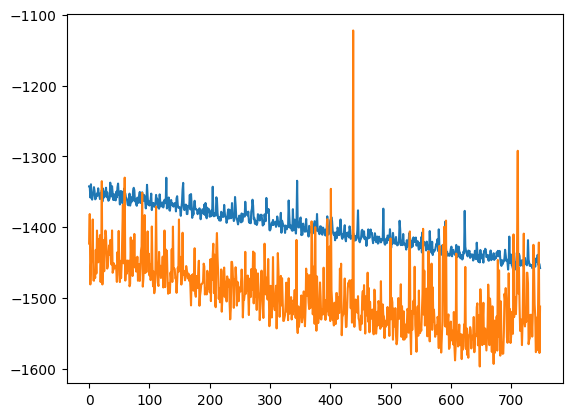

alpha 0.2 default_lr 0.0005


In [40]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [41]:
print(datetime.datetime.now())

2023-07-23 19:58:19.364701


# Iter 5

In [42]:
policy_evaluation_iter=4

In [43]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45
predict diverge [ -5.61333425 -11.3733401   -4.14020752 -46.88933828] [ -0.02853283  -3.64606011  -0.23149826 -26.93522634] [19.307684   8.8250065 51.54092   22.740385 ] [ 9.653842   4.4125032 25.77046   11.370193 ] sim_timestep 112

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [44]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.71471  validloss 1.08157±0.00000  bestvalidloss 1.08157  last_update 0
train: iter 1  trainloss 0.68704  validloss 0.87227±0.00000  bestvalidloss 0.87227  last_update 0
train: iter 2  trainloss 0.67953  validloss 0.89846±0.00000  bestvalidloss 0.87227  last_update 1
train: iter 3  trainloss 0.67090  validloss 0.89603±0.00000  bestvalidloss 0.87227  last_update 2
train: iter 4  trainloss 0.67168  validloss 0.89477±0.00000  bestvalidloss 0.87227  last_update 3
train: iter 5  trainloss 0.67685  validloss 0.91375±0.00000  bestvalidloss 0.87227  last_update 4
train: iter 6  trainloss 0.67266  validloss 0.88987±0.00000  bestvalidloss 0.87227  last_update 5
train: iter 7  trainloss 0.66186  validloss 0.89279±0.00000  bestvalidloss 0.87227  last_update 6
train: iter 8  trainloss 0.66261  validloss 0.87779±0.00000  bestvalidloss 0.87227  last_update 7
train: iter 9  trainloss 0.66014  validloss 0.87293±0.00000  bestvalidloss 0.87227  last_update 8
train: iter 10  trai

train: iter 83  trainloss 0.62725  validloss 0.95106±0.00000  bestvalidloss 0.86250  last_update 67
train: iter 84  trainloss 0.63760  validloss 0.96022±0.00000  bestvalidloss 0.86250  last_update 68
train: iter 85  trainloss 0.63642  validloss 0.95259±0.00000  bestvalidloss 0.86250  last_update 69
train: iter 86  trainloss 0.62850  validloss 0.91794±0.00000  bestvalidloss 0.86250  last_update 70
train: iter 87  trainloss 0.63295  validloss 0.96696±0.00000  bestvalidloss 0.86250  last_update 71
train: iter 88  trainloss 0.62788  validloss 0.95356±0.00000  bestvalidloss 0.86250  last_update 72
train: iter 89  trainloss 0.62871  validloss 0.96210±0.00000  bestvalidloss 0.86250  last_update 73
train: iter 90  trainloss 0.63556  validloss 0.94558±0.00000  bestvalidloss 0.86250  last_update 74
train: iter 91  trainloss 0.63151  validloss 0.97677±0.00000  bestvalidloss 0.86250  last_update 75
train: iter 92  trainloss 0.63210  validloss 0.96552±0.00000  bestvalidloss 0.86250  last_update 76


In [45]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -8.270105062067511
valid_loss:  -22.585791097259523
weight_alpha 1.0 h_min_tilde -12.323147 ell_tilde -11.133242269105914 kappa_tilde 0.0009167352631009992
train_loss:  -6.701791659259797
valid_loss:  -6.885429059791565
weight_alpha 0.2 h_min_tilde -12.323147 ell_tilde -6.738519139366151 kappa_tilde 0.00042315832335489904


In [46]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.2
train_weighted_vae: enc_dec
train: iter 0  trainloss -1351.22247  validloss -1385.27531±0.00000  bestvalidloss -1385.27531  last_update 0
train: iter 1  trainloss -1355.07604  validloss -1477.89467±0.00000  bestvalidloss -1477.89467  last_update 0
train: iter 2  trainloss -1358.59065  validloss -1476.37978±0.00000  bestvalidloss -1477.89467  last_update 1
train: iter 3  trainloss -1354.73678  validloss -1282.99324±0.00000  bestvalidloss -1477.89467  last_update 2
train: iter 4  trainloss -1347.46919  validloss -1438.10658±0.00000  bestvalidloss -1477.89467  last_update 3
train: iter 5  trainloss -1355.63839  validloss -1476.67290±0.00000  bestvalidloss -1477.89467  last_update 4
train: iter 6  trainloss -1352.50981  validloss -1519.34441±0.00000  bestvalidloss -1519.34441  last_update 0
train: iter 7  trainloss -1351.61229  validloss -1430.28145±0.00000  bestvalidloss -1519.34441  last_update 1
train: iter 8  trainloss -1361.13420  validloss -1495.63156±0.00000  bestva

train: iter 74  trainloss -1364.99275  validloss -1534.57860±0.00000  bestvalidloss -1567.72635  last_update 13
train: iter 75  trainloss -1368.76178  validloss -1526.61291±0.00000  bestvalidloss -1567.72635  last_update 14
train: iter 76  trainloss -1371.70673  validloss -1449.66167±0.00000  bestvalidloss -1567.72635  last_update 15
train: iter 77  trainloss -1376.80313  validloss -1478.26296±0.00000  bestvalidloss -1567.72635  last_update 16
train: iter 78  trainloss -1369.04459  validloss -1504.16446±0.00000  bestvalidloss -1567.72635  last_update 17
train: iter 79  trainloss -1378.27569  validloss -1498.06593±0.00000  bestvalidloss -1567.72635  last_update 18
train: iter 80  trainloss -1337.86134  validloss -1488.46125±0.00000  bestvalidloss -1567.72635  last_update 19
train: iter 81  trainloss -1358.79399  validloss -1554.68891±0.00000  bestvalidloss -1567.72635  last_update 20
train: iter 82  trainloss -1358.89760  validloss -1502.40409±0.00000  bestvalidloss -1567.72635  last_up

train: iter 147  trainloss -1381.61138  validloss -1481.81158±0.00000  bestvalidloss -1567.72635  last_update 86
train: iter 148  trainloss -1377.33303  validloss -1527.36162±0.00000  bestvalidloss -1567.72635  last_update 87
train: iter 149  trainloss -1381.67344  validloss -1559.29386±0.00000  bestvalidloss -1567.72635  last_update 88
train: iter 150  trainloss -1379.94537  validloss -1513.95788±0.00000  bestvalidloss -1567.72635  last_update 89
train: iter 151  trainloss -1378.75373  validloss -1518.48515±0.00000  bestvalidloss -1567.72635  last_update 90
train: iter 152  trainloss -1365.81184  validloss -1490.81412±0.00000  bestvalidloss -1567.72635  last_update 91
train: iter 153  trainloss -1380.88558  validloss -1440.59285±0.00000  bestvalidloss -1567.72635  last_update 92
train: iter 154  trainloss -1387.70574  validloss -1525.34863±0.00000  bestvalidloss -1567.72635  last_update 93
train: iter 155  trainloss -1388.81776  validloss -1520.22357±0.00000  bestvalidloss -1567.72635

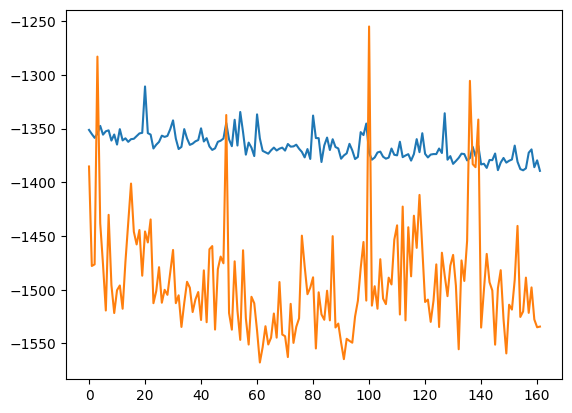

alpha 0.2 default_lr 0.0005


In [47]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [48]:
print(datetime.datetime.now())

2023-07-23 20:22:29.722212


# 評価関数計算

In [49]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4
predict diverge [ -8.4522494   -9.19609348  -4.18309783 -17.17120574] [-0.09023829 -0.54725008 -0.22189816 -1.7065408 ] [19.307684   8.8250065 51.54092   22.740385 ] [ 9.653842   4.4125032 25.77046   11.370193 ] sim_timestep 133

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24
predict diverge [ -4.03281773  -9.00437138  -3.12412643 -11.12309393] [-0.15335248 -0.70022942 -0.13701171 -0.93405098] [19.307684   8.8250065 51.54092   22.740385 ] [ 9.653842   4.4125032 25.77046   11.370193 ] sim_timestep 72

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44
predict diverge [ -3.61932936  -9.72165937  -3.2342777  -11.09092919] [-0.1318506  -0.93611497 -0.09122394 -0.75482704] [19.307684   8.8250065 51.54092   22.740385 ] [ 9.653842   4.4125032 25.77046   11.370193 ] sim_timestep 122

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

In [50]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.66649  validloss 1.05298±0.00000  bestvalidloss 1.05298  last_update 0
train: iter 1  trainloss 0.65662  validloss 0.93992±0.00000  bestvalidloss 0.93992  last_update 0
train: iter 2  trainloss 0.65758  validloss 0.98361±0.00000  bestvalidloss 0.93992  last_update 1
train: iter 3  trainloss 0.65581  validloss 0.98518±0.00000  bestvalidloss 0.93992  last_update 2
train: iter 4  trainloss 0.64411  validloss 0.97546±0.00000  bestvalidloss 0.93992  last_update 3
train: iter 5  trainloss 0.64945  validloss 1.01509±0.00000  bestvalidloss 0.93992  last_update 4
train: iter 6  trainloss 0.65138  validloss 0.93359±0.00000  bestvalidloss 0.93359  last_update 0
train: iter 7  trainloss 0.64561  validloss 0.98359±0.00000  bestvalidloss 0.93359  last_update 1
train: iter 8  trainloss 0.64466  validloss 1.01226±0.00000  bestvalidloss 0.93359  last_update 2
train: iter 9  trainloss 0.64967  validloss 0.94751±0.00000  bestvalidloss 0.93359  last_update 3
train: iter 10  trai

train: iter 83  trainloss 0.62184  validloss 0.92439±0.00000  bestvalidloss 0.89861  last_update 2
train: iter 84  trainloss 0.63279  validloss 1.02922±0.00000  bestvalidloss 0.89861  last_update 3
train: iter 85  trainloss 0.62034  validloss 0.98409±0.00000  bestvalidloss 0.89861  last_update 4
train: iter 86  trainloss 0.62920  validloss 1.02062±0.00000  bestvalidloss 0.89861  last_update 5
train: iter 87  trainloss 0.62044  validloss 0.94518±0.00000  bestvalidloss 0.89861  last_update 6
train: iter 88  trainloss 0.62378  validloss 0.93311±0.00000  bestvalidloss 0.89861  last_update 7
train: iter 89  trainloss 0.62594  validloss 0.98955±0.00000  bestvalidloss 0.89861  last_update 8
train: iter 90  trainloss 0.62805  validloss 0.96019±0.00000  bestvalidloss 0.89861  last_update 9
train: iter 91  trainloss 0.62433  validloss 0.95698±0.00000  bestvalidloss 0.89861  last_update 10
train: iter 92  trainloss 0.62268  validloss 0.94247±0.00000  bestvalidloss 0.89861  last_update 11
train: i

train: iter 166  trainloss 0.61063  validloss 1.02086±0.00000  bestvalidloss 0.89861  last_update 85
train: iter 167  trainloss 0.60947  validloss 0.96945±0.00000  bestvalidloss 0.89861  last_update 86
train: iter 168  trainloss 0.61033  validloss 0.93328±0.00000  bestvalidloss 0.89861  last_update 87
train: iter 169  trainloss 0.61152  validloss 0.99648±0.00000  bestvalidloss 0.89861  last_update 88
train: iter 170  trainloss 0.61106  validloss 0.95853±0.00000  bestvalidloss 0.89861  last_update 89
train: iter 171  trainloss 0.60871  validloss 0.95257±0.00000  bestvalidloss 0.89861  last_update 90
train: iter 172  trainloss 0.61198  validloss 0.97970±0.00000  bestvalidloss 0.89861  last_update 91
train: iter 173  trainloss 0.60985  validloss 0.99357±0.00000  bestvalidloss 0.89861  last_update 92
train: iter 174  trainloss 0.60848  validloss 0.95946±0.00000  bestvalidloss 0.89861  last_update 93
train: iter 175  trainloss 0.60903  validloss 1.03271±0.00000  bestvalidloss 0.89861  last_

([0.6664923127740622,
  0.6566222524270415,
  0.6575794380158186,
  0.6558057641610503,
  0.6441149484366179,
  0.6494535574689507,
  0.651375044696033,
  0.6456116542220116,
  0.6446590146049858,
  0.6496658593416214,
  0.646420013718307,
  0.6461964705958962,
  0.6405766827985644,
  0.649081927165389,
  0.6438182603567839,
  0.6370075572282076,
  0.6408523406833411,
  0.636789676360786,
  0.6392551627010107,
  0.6461618687957525,
  0.6390011796727777,
  0.6390032678842544,
  0.6392738498747349,
  0.6429080836474895,
  0.6437357522547245,
  0.6352146277204156,
  0.6422345343977213,
  0.6350589606910944,
  0.6359946936368942,
  0.6394219780340791,
  0.6365085788071155,
  0.636928484402597,
  0.6407332114875317,
  0.636402223072946,
  0.6379263056442142,
  0.633511014468968,
  0.6388104125857353,
  0.6353195760399103,
  0.6375207446515561,
  0.6350384563207626,
  0.6332858398556709,
  0.6339813763275742,
  0.6296059822663664,
  0.6320488946512341,
  0.6312669465318322,
  0.6300472293049

In [51]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -8.139250505936145
valid_loss:  -23.76186341457367
weight_alpha 1.0 h_min_tilde -12.323593 ell_tilde -11.263773087663651 kappa_tilde 0.000971368316706178
train_loss:  -6.464704750156403
valid_loss:  -7.144843753051758
weight_alpha 0.2 h_min_tilde -12.323593 ell_tilde -6.600732550735475 kappa_tilde 0.0004180164924267453


In [52]:
train_curve, valid_curve = iwvi.train_initial_belief(num_iter=100000, lr=1e-3, early_stop_step=default_early)


train: iter 0  trainloss 94.55558  validloss 95.76896±0.00000  bestvalidloss 95.76896  last_update 0
train: iter 1  trainloss 79.51580  validloss 81.17462±0.00000  bestvalidloss 81.17462  last_update 0
train: iter 2  trainloss 68.16522  validloss 67.88991±0.00000  bestvalidloss 67.88991  last_update 0
train: iter 3  trainloss 58.47726  validloss 57.11029±0.00000  bestvalidloss 57.11029  last_update 0
train: iter 4  trainloss 50.87238  validloss 47.92554±0.00000  bestvalidloss 47.92554  last_update 0
train: iter 5  trainloss 44.42723  validloss 41.96812±0.00000  bestvalidloss 41.96812  last_update 0
train: iter 6  trainloss 39.62895  validloss 34.66846±0.00000  bestvalidloss 34.66846  last_update 0
train: iter 7  trainloss 34.74039  validloss 30.95840±0.00000  bestvalidloss 30.95840  last_update 0
train: iter 8  trainloss 31.43290  validloss 26.73611±0.00000  bestvalidloss 26.73611  last_update 0
train: iter 9  trainloss 28.03722  validloss 23.40862±0.00000  bestvalidloss 23.40862  last

train: iter 84  trainloss 2.33467  validloss 0.75264±0.00000  bestvalidloss 0.73431  last_update 3
train: iter 85  trainloss 2.30140  validloss 0.69039±0.00000  bestvalidloss 0.69039  last_update 0
train: iter 86  trainloss 2.24860  validloss 0.68771±0.00000  bestvalidloss 0.68771  last_update 0
train: iter 87  trainloss 2.18914  validloss 0.68368±0.00000  bestvalidloss 0.68368  last_update 0
train: iter 88  trainloss 2.18016  validloss 0.66055±0.00000  bestvalidloss 0.66055  last_update 0
train: iter 89  trainloss 2.11142  validloss 0.64482±0.00000  bestvalidloss 0.64482  last_update 0
train: iter 90  trainloss 2.07760  validloss 0.64566±0.00000  bestvalidloss 0.64482  last_update 1
train: iter 91  trainloss 2.04744  validloss 0.59869±0.00000  bestvalidloss 0.59869  last_update 0
train: iter 92  trainloss 2.01791  validloss 0.59015±0.00000  bestvalidloss 0.59015  last_update 0
train: iter 93  trainloss 1.99546  validloss 0.63780±0.00000  bestvalidloss 0.59015  last_update 1
train: ite

train: iter 169  trainloss 1.28581  validloss 0.63997±0.00000  bestvalidloss 0.50561  last_update 52
train: iter 170  trainloss 1.27865  validloss 0.66286±0.00000  bestvalidloss 0.50561  last_update 53
train: iter 171  trainloss 1.27628  validloss 0.65386±0.00000  bestvalidloss 0.50561  last_update 54
train: iter 172  trainloss 1.28429  validloss 0.66408±0.00000  bestvalidloss 0.50561  last_update 55
train: iter 173  trainloss 1.27000  validloss 0.64780±0.00000  bestvalidloss 0.50561  last_update 56
train: iter 174  trainloss 1.27080  validloss 0.64804±0.00000  bestvalidloss 0.50561  last_update 57
train: iter 175  trainloss 1.25722  validloss 0.65647±0.00000  bestvalidloss 0.50561  last_update 58
train: iter 176  trainloss 1.27731  validloss 0.65410±0.00000  bestvalidloss 0.50561  last_update 59
train: iter 177  trainloss 1.26296  validloss 0.64556±0.00000  bestvalidloss 0.50561  last_update 60
train: iter 178  trainloss 1.26761  validloss 0.65843±0.00000  bestvalidloss 0.50561  last_

In [53]:
print(iwvi.initial_belief)


Parameter containing:
tensor([-0.8269, -1.5238, -2.1553, -1.7646], requires_grad=True)


In [54]:
train_curve, valid_curve = iwvi.train_penalty(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early)

train: iter 0  trainloss 3.00494  validloss 38.94755±0.00000  bestvalidloss 38.94755  last_update 0
train: iter 1  trainloss 1.35972  validloss 40.49726±0.00000  bestvalidloss 38.94755  last_update 1
train: iter 2  trainloss 1.29294  validloss 43.92295±0.00000  bestvalidloss 38.94755  last_update 2
train: iter 3  trainloss 1.31003  validloss 44.03390±0.00000  bestvalidloss 38.94755  last_update 3
train: iter 4  trainloss 1.27449  validloss 42.13318±0.00000  bestvalidloss 38.94755  last_update 4
train: iter 5  trainloss 1.29796  validloss 43.38371±0.00000  bestvalidloss 38.94755  last_update 5
train: iter 6  trainloss 1.19472  validloss 41.46537±0.00000  bestvalidloss 38.94755  last_update 6
train: iter 7  trainloss 1.23346  validloss 40.53074±0.00000  bestvalidloss 38.94755  last_update 7
train: iter 8  trainloss 1.26615  validloss 39.46735±0.00000  bestvalidloss 38.94755  last_update 8
train: iter 9  trainloss 1.24057  validloss 40.36429±0.00000  bestvalidloss 38.94755  last_update 9


train: iter 83  trainloss 1.09132  validloss 41.08289±0.00000  bestvalidloss 38.08907  last_update 65
train: iter 84  trainloss 1.15305  validloss 44.61382±0.00000  bestvalidloss 38.08907  last_update 66
train: iter 85  trainloss 1.11796  validloss 41.20985±0.00000  bestvalidloss 38.08907  last_update 67
train: iter 86  trainloss 1.13871  validloss 44.10735±0.00000  bestvalidloss 38.08907  last_update 68
train: iter 87  trainloss 1.05659  validloss 43.40933±0.00000  bestvalidloss 38.08907  last_update 69
train: iter 88  trainloss 1.13028  validloss 41.35865±0.00000  bestvalidloss 38.08907  last_update 70
train: iter 89  trainloss 1.15162  validloss 44.33661±0.00000  bestvalidloss 38.08907  last_update 71
train: iter 90  trainloss 1.13784  validloss 40.32686±0.00000  bestvalidloss 38.08907  last_update 72
train: iter 91  trainloss 1.08135  validloss 40.71973±0.00000  bestvalidloss 38.08907  last_update 73
train: iter 92  trainloss 1.10047  validloss 43.98988±0.00000  bestvalidloss 38.08

In [55]:
iwvi.save(ckpt_key="policy_optimization_iter1")

iwvi save ckpt1, ckpt2 ckpt_iwvi_basepartcartpole_policy_optimization_iter1 ckpt_iwvi_cartpole_policy_optimization_iter1
base save ckpt ckpt_basevi_cartpole_policy_optimization_iter1
base load self.initial_belief.data.sum() tensor(-6.2707)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(4.9619)


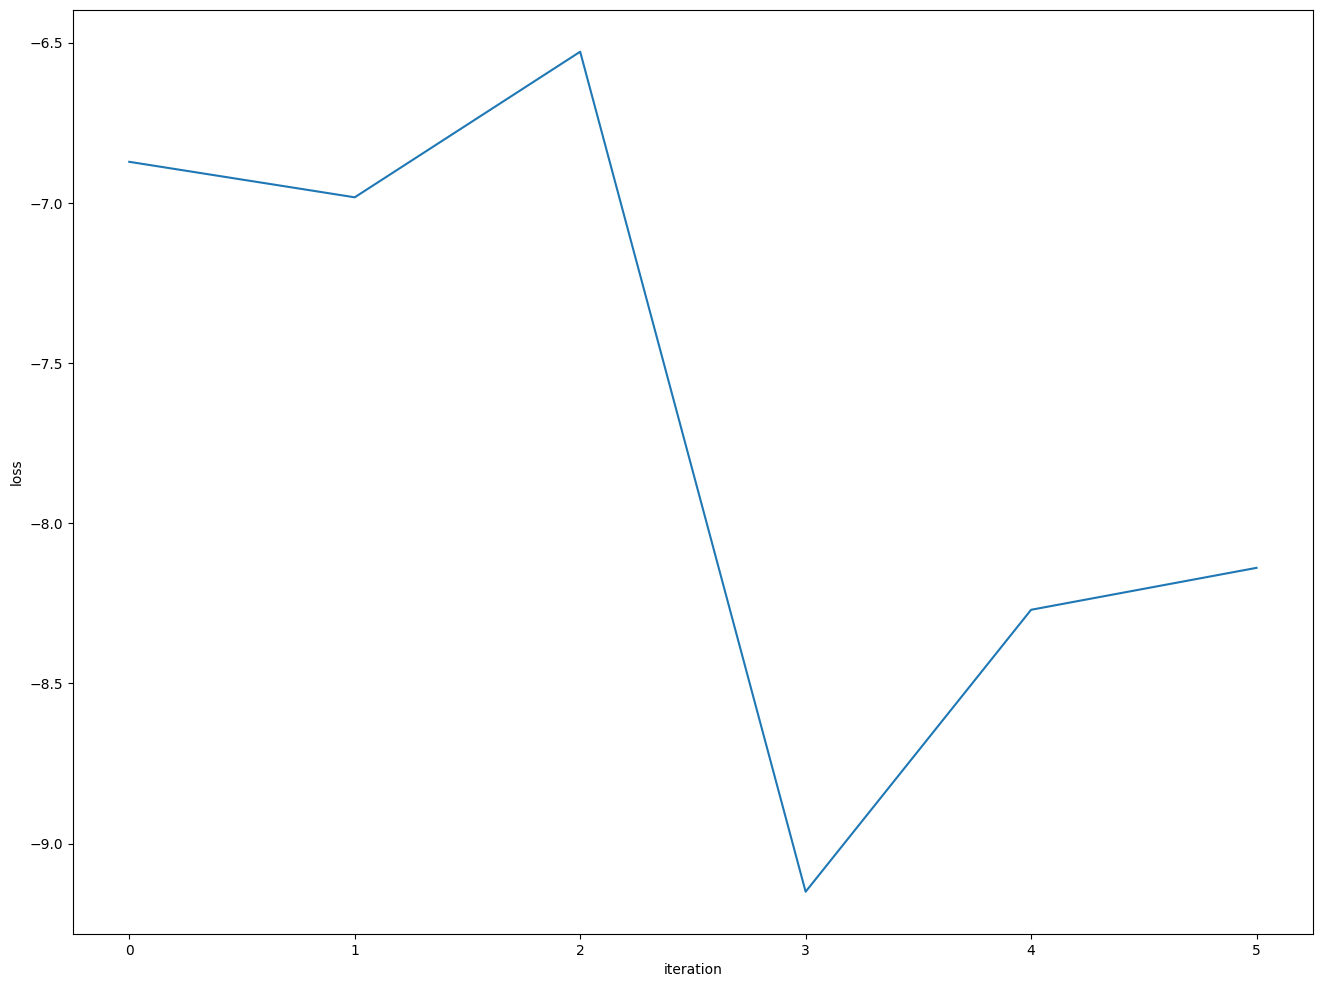

In [56]:
loss_array = np.array(loss_list)
plt.figure(figsize=(16,12))
plt.plot(loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve.png")
plt.savefig(figfilenamehead+"learning_curve.eps")
# plt.savefig(figfilenamehead+"policy_evaluartion_learning_curve.pdf")

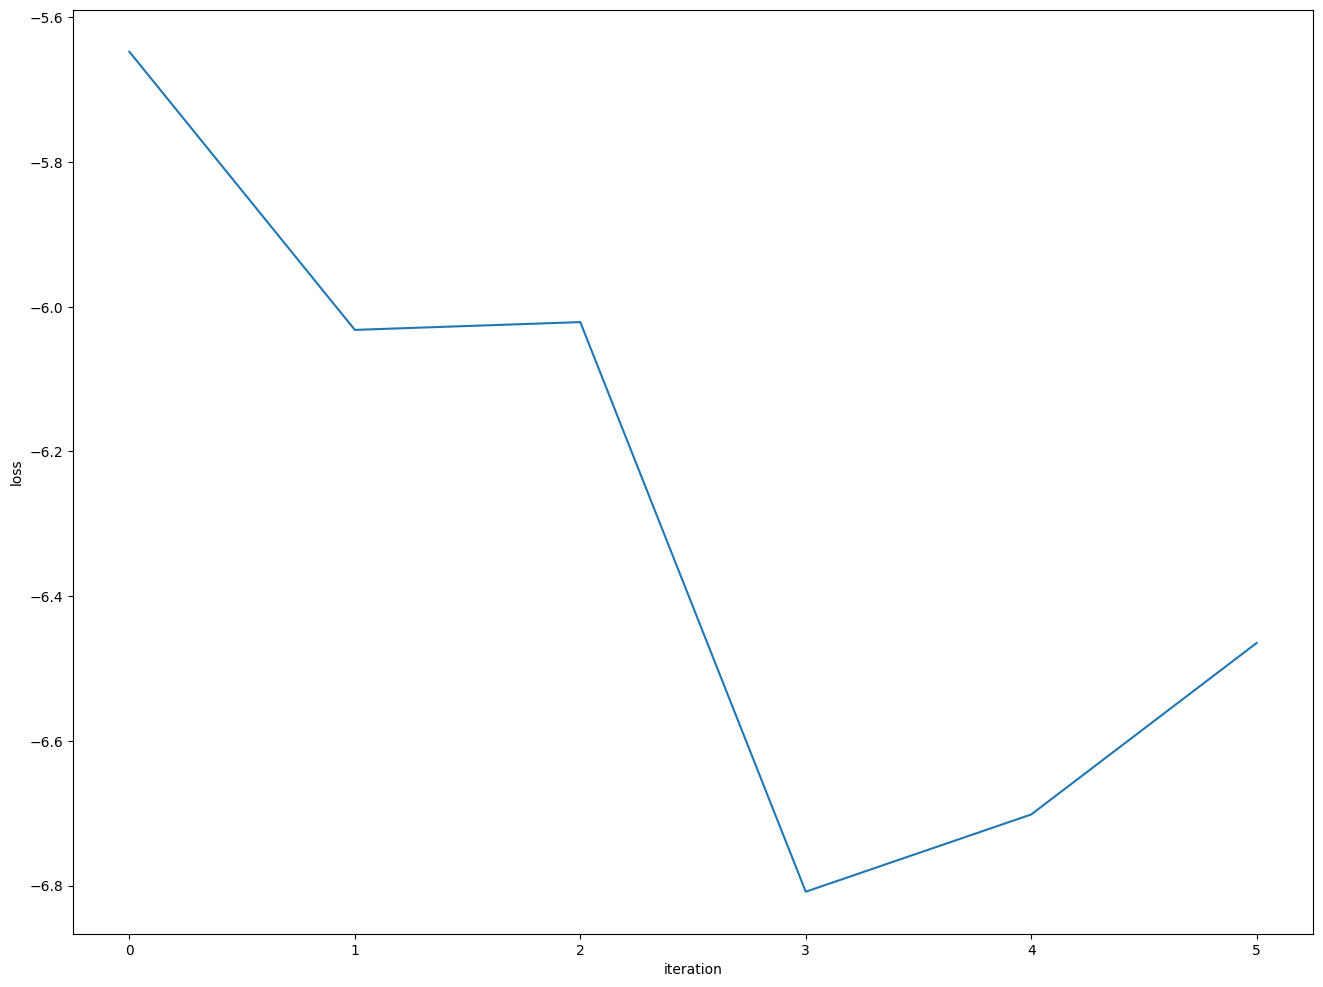

In [57]:
normalized_loss_array = np.array(normalized_loss_list)
plt.figure(figsize=(16,12))
plt.plot(normalized_loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".png")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".eps")